In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils

%matplotlib notebook

In [2]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

In [517]:
# Get all data sets
visual_areas = ['V1', 'Lm', 'Li']
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [519]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
with open(sdata_fpath, 'rb') as f:
    sdata = pkl.load(f)

In [521]:
cells, missing_seg = seg.get_cells_by_area(sdata, return_missing=True)


Segmentation: missing 9 dsets


In [522]:
'20190502_JC076_fov1' in cells['datakey'].values

False

In [608]:
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'
trial_epoch='plushalf'
response_type='dff'

stack_neuraldf = False

#### Check for equal trial counts
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch,
                        visual_area=curr_visual_area, datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=False)

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            652   652       652      652      652     652        652
Lm           1131  1131      1131     1131     1131    1131       1131
V1           1251  1251      1251     1251     1251    1251       1251

In [611]:
'20191105_JC117_fov1' in MEANS.keys()

True

In [609]:
'20190502_JC076_fov1' in sdata['datakey'].values

False

In [140]:
#all_cells[all_cells['datakey']=='20191105_JC117_fov1']

NameError: name 'a' is not defined

In [612]:
overlap_thr=None
has_retino=False
threshold_dff=False
threshold_snr=False
match_distns = False
remove_too_few=False
min_ncells=5


#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 


stack_neuraldf = True
NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                threshold_snr=threshold_snr, remove_too_few=remove_too_few, min_ncells=min_ncells,
                threshold_dff=threshold_dff) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)
print("Max/min (%s): %.2f, %.2f" % (response_type, NDATA['response'].max(), NDATA['response'].min()))

~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1131, u'Li': 652}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1131, u'Li': 652}
Max/min (dff): 4.97, -0.56


In [613]:
# nd = aggr.unstacked_neuraldf_to_stacked(MEANS['20190510_JC083_fov1'])


In [614]:
NDATA[NDATA['response']>1000]

Empty DataFrame
Columns: [visual_area, datakey, config, trial, cell, response]
Index: []

In [615]:
data_id = '%s_%s_%s' % (traceid, response_str, trial_epoch)
data_id

'traces001_dff_ROC-thr-0.05_plushalf'

In [145]:
del MEANS
del all_cells


# Selectivity & Tolerance

In [705]:
def get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False):
    best_y = float(df[df['response']==df.groupby([x])['response'].max().max()][y])
    df_ = df[df[y]==best_y]
    #df_[y] = best_y
    
    if normalize:
        max_d = float(df_['response'].max())
        df_['response'] = df_['response']/max_d
    
    return df_
        
def get_x_curves_at_given_size(df, x='morphlevel', y='size', val_y=None, normalize=False):
    #val_y = float(df[df['response']==df.groupby([x])['response'].min().min()][y])
    df_ = df[df[y]==val_y]
    #df_[y] = best_y
    
    if normalize:
        max_d = float(df_['response'].max())
        df_['response'] = df_['response']/max_d
    
    return df_
        

def assign_morph_ix(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False)
    else:
        df_ = df.copy()
    mt = morph_tuning_index(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])

def morph_tuning_index(responses):
    '''
    MT = [n - (sum(Ri)/Rmax)]/(n - 1)
    from: Zoccolan et al, 2007
    '''
    n = float(len(responses))
    Rmax = max(responses)
    mt = (n - (sum(responses)/Rmax)) / (n-1)
    
    return mt


def assign_size_tolerance(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='size', y='morphlevel', normalize=False)
    else:
        df_ = df.copy()
    mt = size_tolerance(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])


def size_tolerance(responses):
    '''
    ST = mean( Rtest / max(Rtest) ), where mean is taken over all sizes
    from: Zoccolan et al, 2007
    '''
    normed_tuning = responses/float(max(responses))
    ST = np.mean(normed_tuning[normed_tuning<1.])
    
    return ST

def assign_sparseness(df):
    mt = sparseness(df['response'].values)
    return pd.Series(mt, name=df['cell'].unique()[0])


def sparseness(responses):
    '''
    num = 1 - [ (sum(Ri)/n)**2 / sum( ((Ri**2)/n) ) ] 
    denom = [1 - (1/n)]
    from:  Zoccolan et al, 2007; Rolls & Tovee, 1995; Vinje and Gallant, 2000; Olshausen and Field, 2004.
    '''
    n = float(len(responses))
    num = 1. - ( (sum(responses)/n)**2 / sum( (responses**2)/n ) )
    denom = (1. - (1./n))
    
    return (num/denom)

In [617]:
def selectivity_and_tolerance(NDATA, SDF, images_only=True):
    d_=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
        #print(dk)
        
        sdf = SDF[dk].copy()
        configs = sdf.index.tolist()
        
        tmpdf = calculate_indices_for_neuraldf(x0[x0.config.isin(configs)], sdf, images_only=images_only)
        tmpdf['visual_area'] = va
        tmpdf['datakey'] = dk
        d_.append(tmpdf)

    ixdf = pd.concat(d_, axis=0).reset_index()
    
    return ixdf


In [626]:
def calculate_indices_for_neuraldf(x0, sdf, images_only=True):
#     if x0['response'].min() < 0:
#         print(x0['response'].min())
#         x0['response'] = x0['response']-x0['response'].min()
    #x0['response'] = x0['response'] - x0['response'].min()
    
    x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    #if rdf['response'].min()<0:
    #rdf['response']  = rdf['response'] - rdf['response'].min()
    #r = rdf['response'].copy()
    #rdf['response'] = np.abs(r - np.nanmean(r))
    
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if images_only:
        rdf = rdf[rdf['morphlevel']!=-1]
    n_images = 45 if images_only else 50

    morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
    size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
    sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

    tmpdf = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1)
    
    return tmpdf


## Set output dir

In [619]:
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'selectivity_tolerance')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance


In [620]:
# def load_corrected_dff_traces(animalid, session, fov, experiment='blobs', traceid='traces001',
#                               return_traces=True, epoch='stimulus', metric='mean', 
#                               rootdir='/n/coxfs01/2p-data'):
#     # Load corrected
#     soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov,
#                                     '*%s_static' % (experiment), 'traces', '%s*' % traceid,
#                                     'data_arrays', 'np_subtracted.npz'))[0]
#     dset = np.load(soma_fpath)
#     Fc = pd.DataFrame(dset['data']) # np_subtracted:  Np-corrected trace, with baseline subtracted

#     # Load raw (pre-neuropil subtraction)
#     raw = np.load(soma_fpath.replace('np_subtracted', 'raw'))
#     F0_raw = pd.DataFrame(raw['f0'])

#     # Calculate df/f
#     dff = Fc.divide(F0_raw) # dff 

#     if return_traces:
#         return dff
#     else:
#         labels = pd.DataFrame(data=dset['labels_data'],columns=dset['labels_columns'])
#         dfmat = aggr.traces_to_trials(dff, labels, epoch=epoch, metric=metric)
#         return dfmat

In [621]:
dk = '20191018_JC113_fov1'
va = 'Li'
x0=NDATA[(NDATA.visual_area==va) & (NDATA['datakey']==dk)].copy()

session, animalid, fovnum = putils.split_datakey_str(dk)
dfmat = aggr.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovnum, return_traces=False,
                                     epoch=trial_epoch)
rois_ = list(x0['cell'].unique())
rois_.append('config')

... calculating F0 for df/f


In [170]:
dfmat[rois_].min().min()

-0.14577480799182066

In [171]:
dfmat.min().min()

-42413.195087386805

In [17]:
d_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    session, animalid, fovnum = putils.split_datakey_str(dk)
    dfmat = load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovnum, return_traces=False,
                                     epoch=trial_epoch)
    rois_ = list(x0['cell'].unique())
    rois_.append('config')
    
    dmat = aggr.unstacked_neuraldf_to_stacked(dfmat[rois_])
    dmat['visual_area'] = va
    dmat['datakey'] = dk
    
    d_.append(dmat)
    

In [18]:
NDATA2 = pd.concat(d_, axis=0)


In [178]:
NDATA2.shape, NDATA.shape

((4488894, 6), (4488894, 6))

In [180]:
NDATA2['response'].min(), NDATA['response'].min()

(-0.3003666610557543, -0.3003666610557543)

In [150]:
fout = os.path.join(stats_dir, '%s-thr%.2f_%s_dff0.pkl' % (responsive_test, responsive_thr, trial_epoch))
# print(fout)
# with open(fout, 'wb') as f:
#     pkl.dump(NDATA2, f, protocol=pkl.HIGHEST_PROTOCOL)

In [152]:
with open(fout, 'rb') as f:
    NDATA2 = pkl.load(f)

In [153]:
NDATA.tail(), NDATA2.tail()

(       visual_area              datakey     config  trial cell  response
 226495          Li  20191111_JC120_fov1  config019   1496  189  0.392173
 226496          Li  20191111_JC120_fov1  config027   1497  189  0.339069
 226497          Li  20191111_JC120_fov1  config016   1498  189  0.264145
 226498          Li  20191111_JC120_fov1  config004   1499  189  0.367401
 226499          Li  20191111_JC120_fov1  config007   1500  189  0.285888,
            config  trial cell  response visual_area              datakey
 144045  config029   1671  390  0.173141          V1  20191006_JC110_fov1
 144046  config027   1672  390  0.247123          V1  20191006_JC110_fov1
 144047  config034   1673  390  0.278300          V1  20191006_JC110_fov1
 144048  config048   1674  390  0.256074          V1  20191006_JC110_fov1
 144049  config003   1675  390  0.285973          V1  20191006_JC110_fov1)

In [161]:
NDATA2['response'].min()

-0.3003666610557543

In [163]:
NDATA2[NDATA2.datakey=='20190606_JC091_fov1']['response'].min()

-0.06687345764890179

In [162]:
NDATA['response'].min()

-50555.90487939138

In [159]:
min([v.min().min() for k, v in MEANS.items()])

-50555.90487939138

## Test with 1 dataset

In [12]:
# if NDATA['response'].min() < 0:
#     print("subtracting min %.2f" % NDATA['response'].min())
#     NDATA['response'] = NDATA['response'] - NDATA['response'].min()
# NDATA['response'].min()

In [13]:
# for (v, k), g in NDATA.groupby(['visual_area', 'datakey']):
#     if g['response'].min() < 0:
#         NDATA['response'].loc[g.index] = g['response'] - g['response'].min()

In [24]:
NDATA['response'].min(), NDATA2['response'].min()

(-0.5562002576917793, -0.3003666610557543)

In [25]:
visual_area = 'V1'
datakey = '20190510_JC083_fov1'


In [30]:
ndf = NDATA[(NDATA.visual_area==visual_area) & (NDATA['datakey']==datakey)].copy()

ndf0 = NDATA2[(NDATA2.visual_area==visual_area) & (NDATA2['datakey']==datakey)].copy()
# for c, g in ndf.groupby(['cell']):
#     ndf0['response'].loc[g.index] = g['response'] - g['response'].min()
print(ndf.shape, ndf0.shape)

thismin = ndf['response'].min()
thatmin = ndf0['response'].min()
print(thismin, thatmin)

((124250, 6), (124250, 6))
(-0.40334947782439934, -0.028099260032372588)


In [29]:
ndf.head()

visual_area              datakey     config  trial cell  response
0          V1  20190510_JC083_fov1  config002      1    0 -0.010698
1          V1  20190510_JC083_fov1  config046      2    0 -0.010856
2          V1  20190510_JC083_fov1  config026      3    0  0.000594
3          V1  20190510_JC083_fov1  config001      4    0 -0.000391
4          V1  20190510_JC083_fov1  config036      5    0  0.016573

In [33]:
ndf0.head()

config  trial cell  response visual_area              datakey
0  config002      1    0  0.173572          V1  20190510_JC083_fov1
1  config046      2    0  0.513503          V1  20190510_JC083_fov1
2  config026      3    0  0.251432          V1  20190510_JC083_fov1
3  config001      4    0  0.210934          V1  20190510_JC083_fov1
4  config036      5    0  0.276967          V1  20190510_JC083_fov1

In [35]:
ndf1 = ndf.copy()
ndf1['response'] = ndf1['response'] - ndf1.groupby(['cell'])['response'].transform('min')

In [17]:
NDATA['response'].min()

-0.3003666610557543

<IPython.core.display.Javascript object>


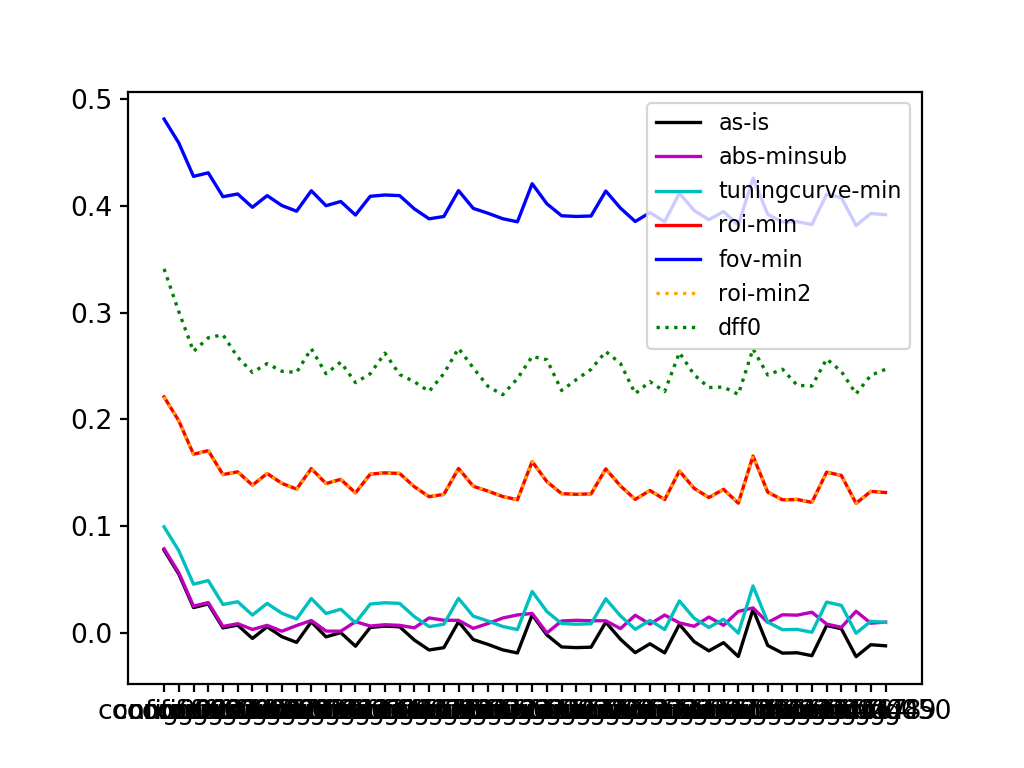

In [41]:
rid = 44
t = ndf0[ndf0['cell']==rid].copy()
#t['response'] = t['response'] - x0['response'].min()
vectest0 = t.groupby(['config']).mean()

t1 = ndf1[ndf1['cell']==rid].copy()
vectest = t1.groupby(['config']).mean()

# ------

x0 = ndf[ndf['cell']==rid]
vec = x0.groupby(['config']).mean()

x1 = x0.copy()
x1['response'] = x0['response'] - x0['response'].min()
vec0 = x1.groupby(['config']).mean()

x2 = x0.copy()
x2['response'] = x0['response'] - thismin
vec00 = x2.groupby(['config']).mean()


vec1 = np.abs(vec['response'] - vec['response'].mean())
vec2 = vec['response'] - vec['response'].min()

pl.figure()
pl.plot(vec['response'], 'k', label='as-is')
pl.plot(vec1, 'm', label='abs-minsub')
pl.plot(vec2, 'c', label='tuningcurve-min')


pl.plot(vec0['response'], 'r', label='roi-min')
pl.plot(vec00['response'], 'b' ,label='fov-min')


pl.plot(vectest['response'], 'orange', linestyle=':', label='roi-min2')
pl.plot(vectest0['response'], 'green', linestyle=':', label='dff0')
pl.legend()

<IPython.core.display.Javascript object>


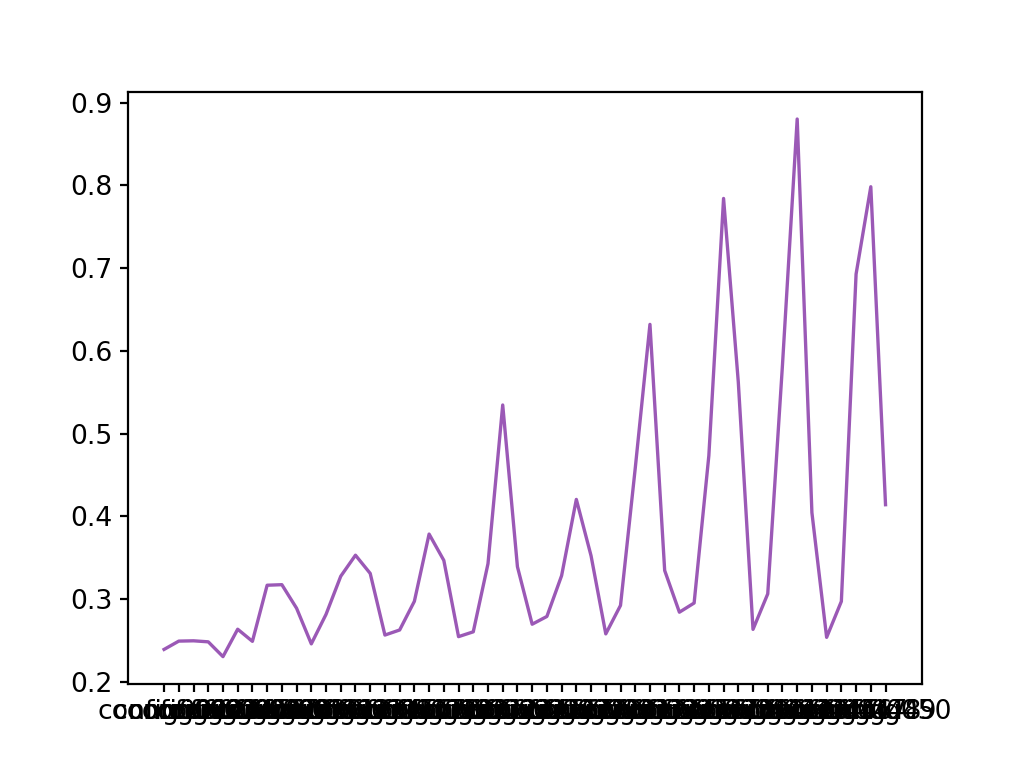

In [1253]:
pl.figure()
pl.plot(vec0['response'])


In [60]:
images_only=True
ixdf = selectivity_and_tolerance(NDATA2, SDF, images_only=True)
ixdf.tail()

cell  size_tol  morph_ix  sparseness visual_area              datakey
2958   364  0.886028  0.076906    0.006244          V1  20191006_JC110_fov1
2959   375  0.944046  0.044360    0.000707          V1  20191006_JC110_fov1
2960   380  0.958668  0.063762    0.000929          V1  20191006_JC110_fov1
2961   383  0.897653  0.044240    0.003294          V1  20191006_JC110_fov1
2962   390  0.931661  0.059924    0.000750          V1  20191006_JC110_fov1

In [61]:
print(ixdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())

Li    18
Lm    17
V1    16
Name: visual_area, dtype: int64


In [62]:
ixdf.min()

cell                             0
size_tol                  0.262897
morph_ix               0.000582765
sparseness             0.000192337
visual_area                     Li
datakey        20190306_JC061_fov3
dtype: object

In [63]:
ixdf.max()

cell                           530
size_tol                  0.985321
morph_ix                  0.545516
sparseness                0.287721
visual_area                     V1
datakey        20191111_JC120_fov1
dtype: object

# Calculate metrics -- Aggregate

In [634]:
images_only=True
ixdf = selectivity_and_tolerance(NDATA, SDF, images_only=True)
ixdf.tail()

cell  size_tol  morph_ix  sparseness visual_area              datakey
3029   364  0.829823  0.113115    0.017712          V1  20191006_JC110_fov1
3030   375  0.809471  0.096838    0.004565          V1  20191006_JC110_fov1
3031   380  0.905538  0.094988    0.003246          V1  20191006_JC110_fov1
3032   383  0.888641  0.074614    0.004641          V1  20191006_JC110_fov1
3033   390  0.902053  0.115427    0.004775          V1  20191006_JC110_fov1

In [635]:
ixdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    19
Lm    18
V1    16
Name: visual_area, dtype: int64

In [636]:
ixdf.min()

cell                             0
size_tol                  0.303209
morph_ix                 0.0156626
sparseness             0.000273964
visual_area                     Li
datakey        20190306_JC061_fov3
dtype: object

In [637]:
ixdf.max()

cell                           530
size_tol                  0.983383
morph_ix                  0.480127
sparseness                0.217726
visual_area                     V1
datakey        20191111_JC120_fov1
dtype: object

#### Drop repeats?

In [20]:
# ixdf0 = ixdf[(ixdf['morph_ix']<=1) & (ixdf['morph_ix']>=0)
#     & (ixdf['sparseness']<=1) & (ixdf['sparseness']>=0)
#     & (ixdf['size_tol']<=1) & (ixdf['size_tol']>=0)].copy()

In [638]:
min_ncells = 10
passdf = pd.concat([g for v, g in ixdf.groupby(['visual_area', 'datakey']) \
                    if (len(g) >= min_ncells) ]) #& (g['morph_ix'])])

In [639]:
passdf['morph_ix'].max()

0.4801273101731681

In [640]:
metric = 'heldout_test_score'
drop_repeats_by = 'most_cells'

# Drop repeat FOVs
pCELLS = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
               for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
pCELLS = putils.split_datakey(pCELLS)

unique_dsets = aggr.select_best_fovs(pCELLS) #, criterion='max', colname='cell')


[V1] Animalid does not exist: JC078 


In [641]:
unique_dsets.shape

(31, 10)

In [642]:
drop_repeats = True
dset_str = 'drop_repeats_%s' % drop_repeats_by if drop_repeats else 'alldata'

excl_dsets = ['20190501_JC076_fov1', '20190627_JC091_fov1'] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']
#excl_dsets = ['20191018_JC113_fov1', '20191111_JC120_fov1']

unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]

passdf_drop = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey'])\
                        if (v, k) in unique_dkeys and k not in excl_dsets])

print("All data:")
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


All data:
             datakey
visual_area         
Li                13
Lm                15
V1                15
Drop repeats:
             datakey
visual_area         
Li                 9
Lm                 9
V1                 8


In [643]:
xdf = passdf_drop.copy() if drop_repeats else passdf.copy()
means_by_fov = xdf.groupby(['visual_area', 'datakey']).mean().reset_index()

ncells_by_fov = xdf.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
mean_indices = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

                   cell  size_tol  morph_ix  sparseness     n_cells
visual_area                                                        
Li           166.207428  0.849690  0.112466    0.006524   51.111111
Lm           136.772129  0.821529  0.123413    0.009576   71.777778
V1           179.944119  0.815167  0.126753    0.014423  124.375000


<IPython.core.display.Javascript object>


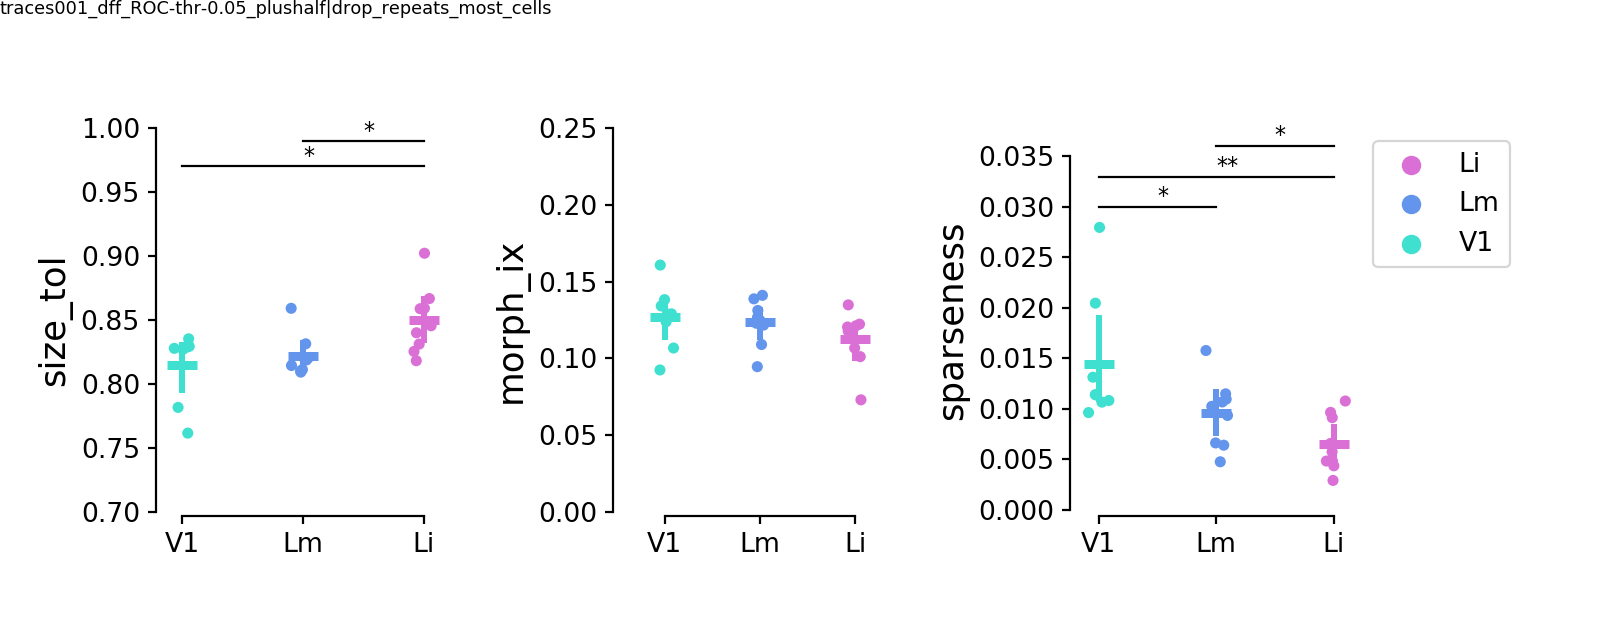

********* [size_tol] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   29.0  V1  Lm   8   9  0.265834   False
1   13.0  V1  Li   8   9  0.022787    True
2   12.0  Lm  Li   9   9  0.020128    True
****************************
********* [morph_ix] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   32.0  V1  Lm   8   9  0.368138   False
1   18.0  V1  Li   8   9  0.069145   False
2   20.0  Lm  Li   9   9  0.069145   False
****************************
********* [sparseness] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   17.0  V1  Lm   8   9  0.037525    True
1    3.0  V1  Li   8   9  0.002646    True
2   18.0  Lm  Li   9   9  0.037525    True
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance', 'aggregate_metrics_dff_fdr_bh__byfov__drop_repeats_most_cells')


In [644]:
plot_cells=False

plot_str = 'bycell' if plot_cells else 'byfov'
if plot_cells:
    plotdf = xdf.copy()
else:
    plotdf = mean_indices.copy()

print(plotdf.groupby(['visual_area']).mean())

fig, axn = pl.subplots(1,3, figsize=(10,4))

ax=axn[0]
multi_comp_test='fdr_bh' #'fdr_bh'

metric='size_tol'
for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
    sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)
    ax.legend_.remove()
    if metric=='size_tol':
        y_loc = 0.95 #0.9
        offset = 0.02
    else:
        y_loc = 0.35 if plot_cells else 0.2
        offset = 0.02 if plot_cells else 0.01
    if metric=='size_tol':
        ax.set_ylim([0.7, 1.0])
    else:
        ax.set_ylim([0, 0.25])
    statresults, ax = aggr.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
                                        multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
ax=axn[2]
metric='sparseness'
y_loc=0.1 if plot_cells else 0.03 #0.008 
offset=0.005 if plot_cells else 0.003
sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)
statresults, ax = aggr.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)


sns.despine(offset=2, trim=True)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.8, wspace=0.6)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1, 1), loc='upper left') #title='pass(p<%.2f)' % p_thr)

for ax in axn.flat:
    ax.set_xlabel('')
    
putils.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'aggregate_metrics_%s_%s__%s__%s' % (response_type, multi_comp_test, plot_str, dset_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [645]:
min_ncells = 10

c_=[]
for (va, dk), ixs_ in xdf.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])
        c = pd.Series({'selectivity': sel_type, 
                   'pearsons_p': pearsons_p, 'pearsons_r': pearsons_r,
                   'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_)})
        c_.append(c)

corrs = pd.concat(c_, axis=1).T

p_thr=0.05
corrs['pass'] = corrs['pearsons_p'] < p_thr

<IPython.core.display.Javascript object>


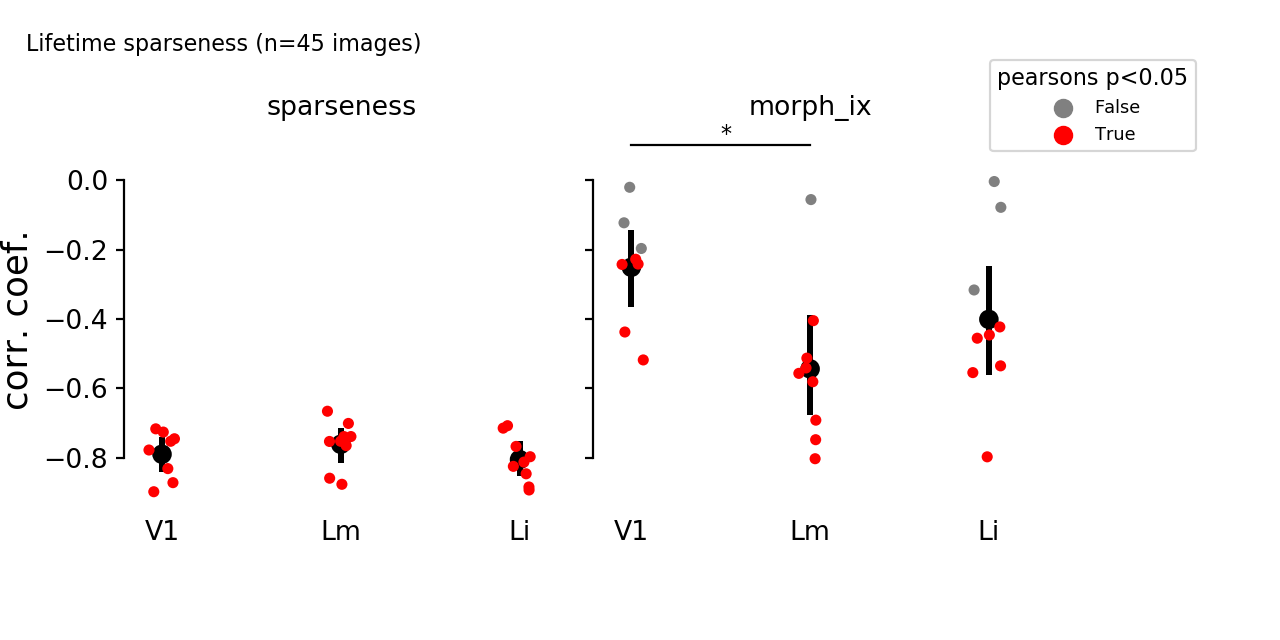

********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   29.0  V1  Lm   8   9  0.398751   False
1   33.0  V1  Li   8   9  0.404947   False
2   24.0  Lm  Li   9   9  0.236557   False
****************************
********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   10.0  V1  Lm   8   9  0.021207    True
1   21.0  V1  Li   8   9  0.081468   False
2   23.0  Lm  Li   9   9  0.081468   False
****************************


Text(0.02,0.92,u'Lifetime sparseness (n=45 images)')

In [646]:
fig, axn = pl.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
n_images = 45 
plotd = corrs.copy() #[corrs['pass']].copy()

ax=axn[0]
for ai, (ax, sel_type) in enumerate(zip(axn.flat, ['sparseness', 'morph_ix'])):
    sns.stripplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 hue='pass', palette={True: 'r', False: 'gray'}, dodge=False, order=visual_areas)
    
    sns.pointplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 color='k', dodge=False, join=False, order=visual_areas)
    y_loc=0.1
    offset=0.1
    statresults, ax = aggr.plot_mannwhitney(plotd[plotd.selectivity==sel_type], metric='pearsons_r', ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
    ax.set_title(sel_type, fontsize=12)
    if ai==0:
        ax.legend_.remove()
        ax.set_ylabel('corr. coef.')
    else:
        ax.set_ylabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

sns.despine(offset=2, trim=True, bottom=True)

aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.9,1.2), loc='upper left', 
                        title='pearsons p<%.2f' % p_thr, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.1)

fig.text(0.02, 0.92, 'Lifetime sparseness (n=%i images)' % n_images)

In [79]:
ixs = passdf[(passdf.visual_area=='V1') & (passdf.datakey=='20190510_JC083_fov1')].copy()
ixs.sort_values(by='size_tol', ascending=False).iloc[0:5]

cell  size_tol  morph_ix  sparseness visual_area              datakey
1931    86  0.974485  0.086004    0.002176          V1  20190510_JC083_fov1
1963   191  0.951705  0.083924    0.001132          V1  20190510_JC083_fov1
1942   124  0.945361  0.104396    0.002548          V1  20190510_JC083_fov1
1923    68  0.945029  0.089282    0.001582          V1  20190510_JC083_fov1
1956   174  0.938161  0.044168    0.000910          V1  20190510_JC083_fov1

# Tradeoff? Look at correlations closer

In [647]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics as skmetrics
import random
import sklearn.utils as skutils

In [648]:
# curr_dsets = [(v, k) for v, k in corrs_drop[['visual_area', 'datakey']].drop_duplicates().values]
# curr_dsets

In [649]:
corrs['n_cells'].min()
print(excl_dsets)

['20190501_JC076_fov1', '20190627_JC091_fov1']


In [650]:
unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]
# curr_df = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey']) \
#                     if ((v, k) in unique_dkeys) & (len(g['cell'].unique())>=min_ncells)])
curr_df = pd.concat([g for (v, k), g in passdf_drop.groupby(['visual_area', 'datakey']) \
                    if (len(g['cell'].unique())>=min_ncells) & (k not in excl_dsets)])

visual_area='V1'

for visual_area in visual_areas:
    vg= curr_df[curr_df.visual_area==visual_area].copy()
    n_fovs = len(vg['datakey'].unique())
    print(visual_area, n_fovs)

('V1', 8)
('Lm', 9)
('Li', 9)


<IPython.core.display.Javascript object>


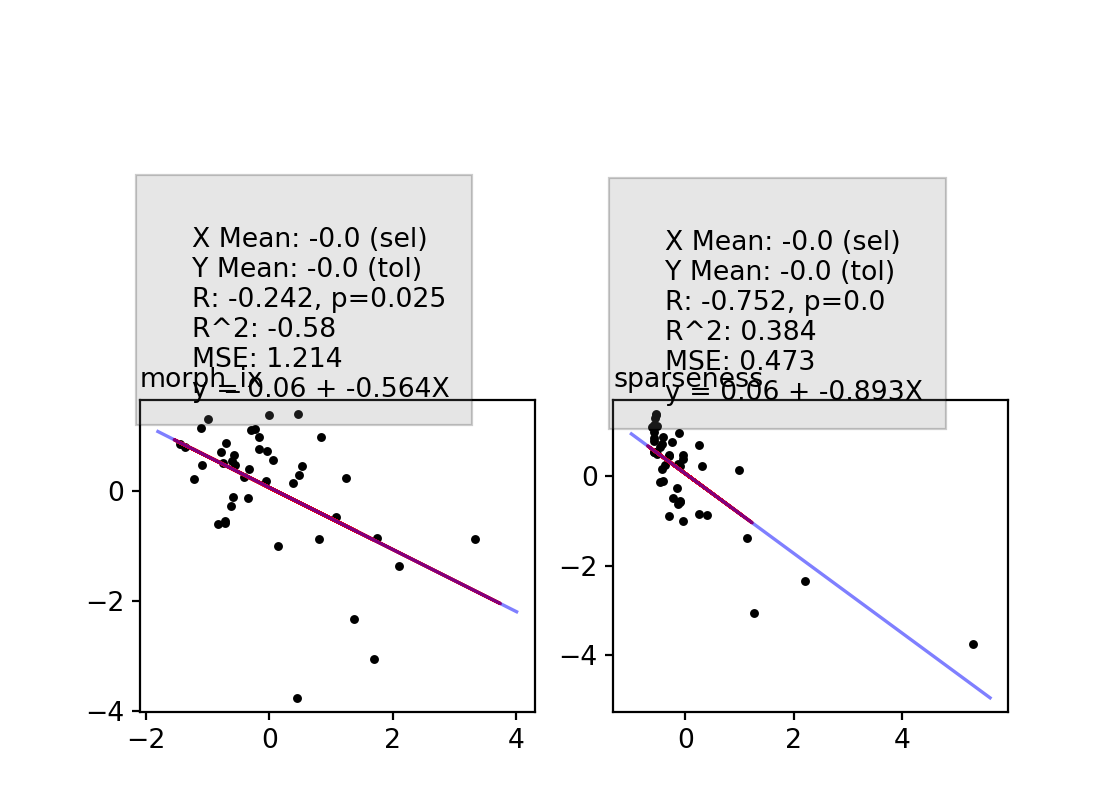

In [651]:
visual_area='V1'
datakey = '20191006_JC110_fov1'
sel_type = 'morph_ix'

ixs_ = passdf[(passdf.visual_area==visual_area) & (passdf.datakey==datakey)].copy()

fig, axn  = pl.subplots(1,2,figsize=(7,5))
for ax, sel_type in zip(axn.flat, ['morph_ix', 'sparseness']):
    xx_ = ixs_[sel_type].values.reshape(-1, 1)
    yy_ = ixs_['size_tol'].values.reshape(-1, 1)
    
    xx = (xx_ - np.mean(xx_)) / np.std(xx_)
    yy = (yy_ - np.mean(yy_)) / np.std(yy_)
    
    X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.5, shuffle=True, random_state=100)
    
    # Fit OLS
    scaler  = preprocessing.StandardScaler().fit(X_train)
    x_train = scaler.transform(X_train)
    regr = linear_model.LinearRegression().fit(x_train, y_train)
    x_test = scaler.transform(X_test)
    y_pred = regr.predict(x_test)
    
    # metrics
    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
    R2 = skmetrics.r2_score(y_test, y_pred)
    MSE = skmetrics.mean_squared_error(y_test, y_pred)
    B0 = float(regr.intercept_)
    B1 = float(regr.coef_)
    res = {'pearsons_r': pearsons_r, 'pearsons_p': pearsons_p, 'R2': R2, 'MSE': MSE, 
           'coef': B0, 'intercept': B1, 'selectivity': sel_type}
    
    ax.scatter(x_train, y_train, color='k', marker='.')
    ax.plot(x_test, y_pred, color='r')
    
    text = '''
    X Mean: {} (sel)
    Y Mean: {} (tol)
    R: {}, p={}
    R^2: {}
    MSE: {}
    y = {} + {}X'''\
                    .format(round(xx.mean(), 2), 
                           round(yy.mean(), 2), 
                           round(pearsons_r, 3), round(pearsons_p, 3), 
                           round(R2, 3),
                           round(MSE, 3),
                           round(B0, 3),
                           round(B1, 3))
    ax.text(x=ax.get_xlim()[0], y=ax.get_ylim()[-1]+.05, s=text, fontsize=12, 
            bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 10})
    
    xmin, xmax = ax.get_xlim()
    xvs = np.linspace(xmin, xmax, num=5)
    ax.plot(xvs, B0 + B1*xvs, c='b', alpha=0.5)
    ax.set_title(sel_type, loc='left')
    
pl.subplots_adjust(top=0.5)



In [75]:
max_nfovs

NameError: name 'max_nfovs' is not defined

In [652]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance'

In [653]:
visual_area, dk, sel_type

('V1', '20191006_JC110_fov1', 'sparseness')

In [654]:
max_nfovs = passdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts().max()
max_nfovs

15

<IPython.core.display.Javascript object>


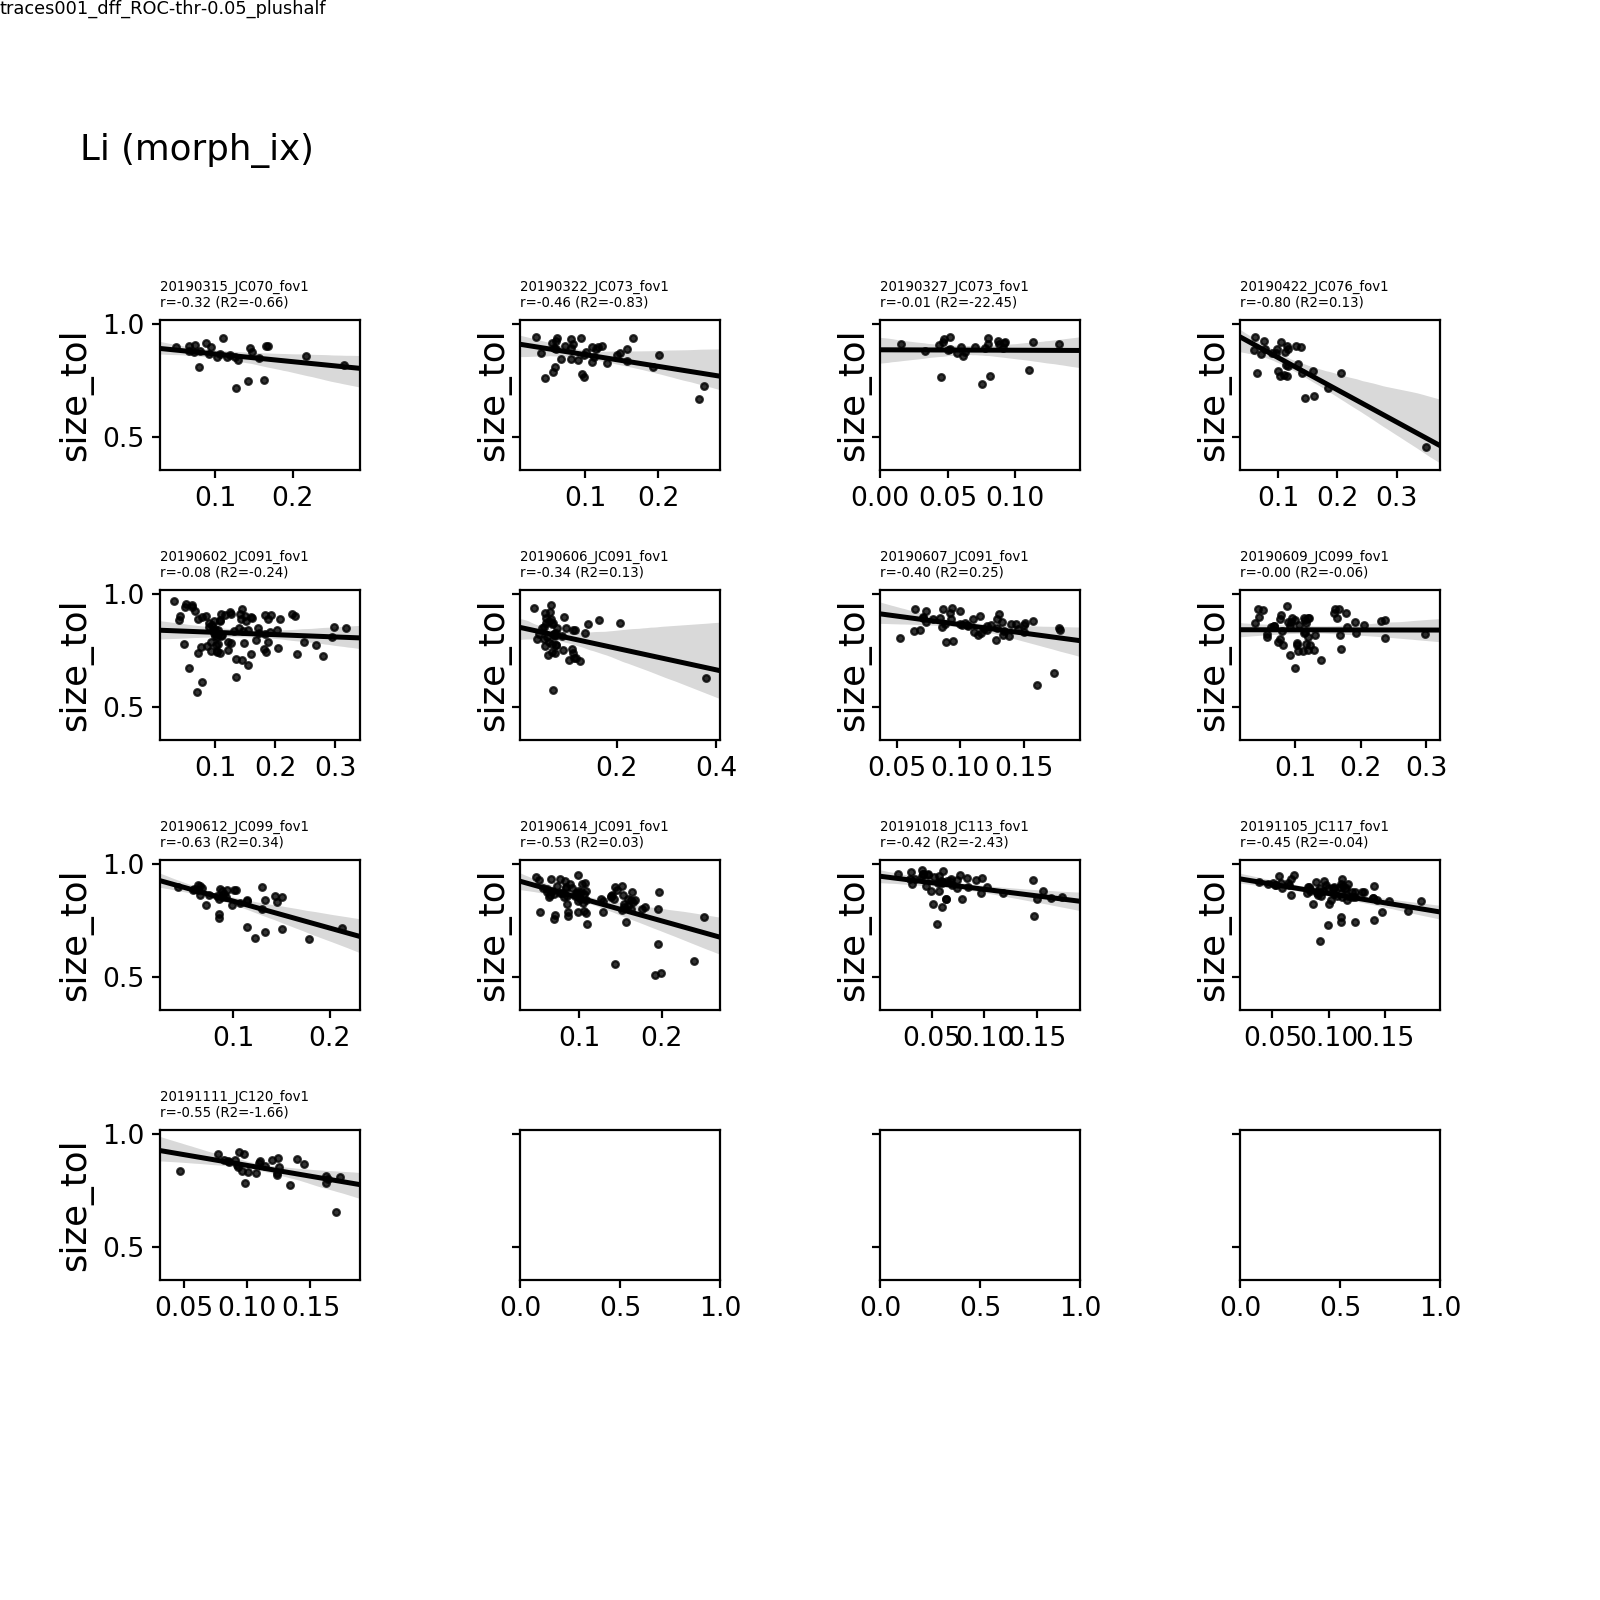

Bad fit: 20190315_JC070_fov1 (R2=-0.66)
Bad fit: 20190322_JC073_fov1 (R2=-0.83)
Bad fit: 20190327_JC073_fov1 (R2=-22.45)
Bad fit: 20190602_JC091_fov1 (R2=-0.24)
Bad fit: 20190609_JC099_fov1 (R2=-0.06)
Bad fit: 20191018_JC113_fov1 (R2=-2.43)
Bad fit: 20191105_JC117_fov1 (R2=-0.04)
Bad fit: 20191111_JC120_fov1 (R2=-1.66)


<IPython.core.display.Javascript object>


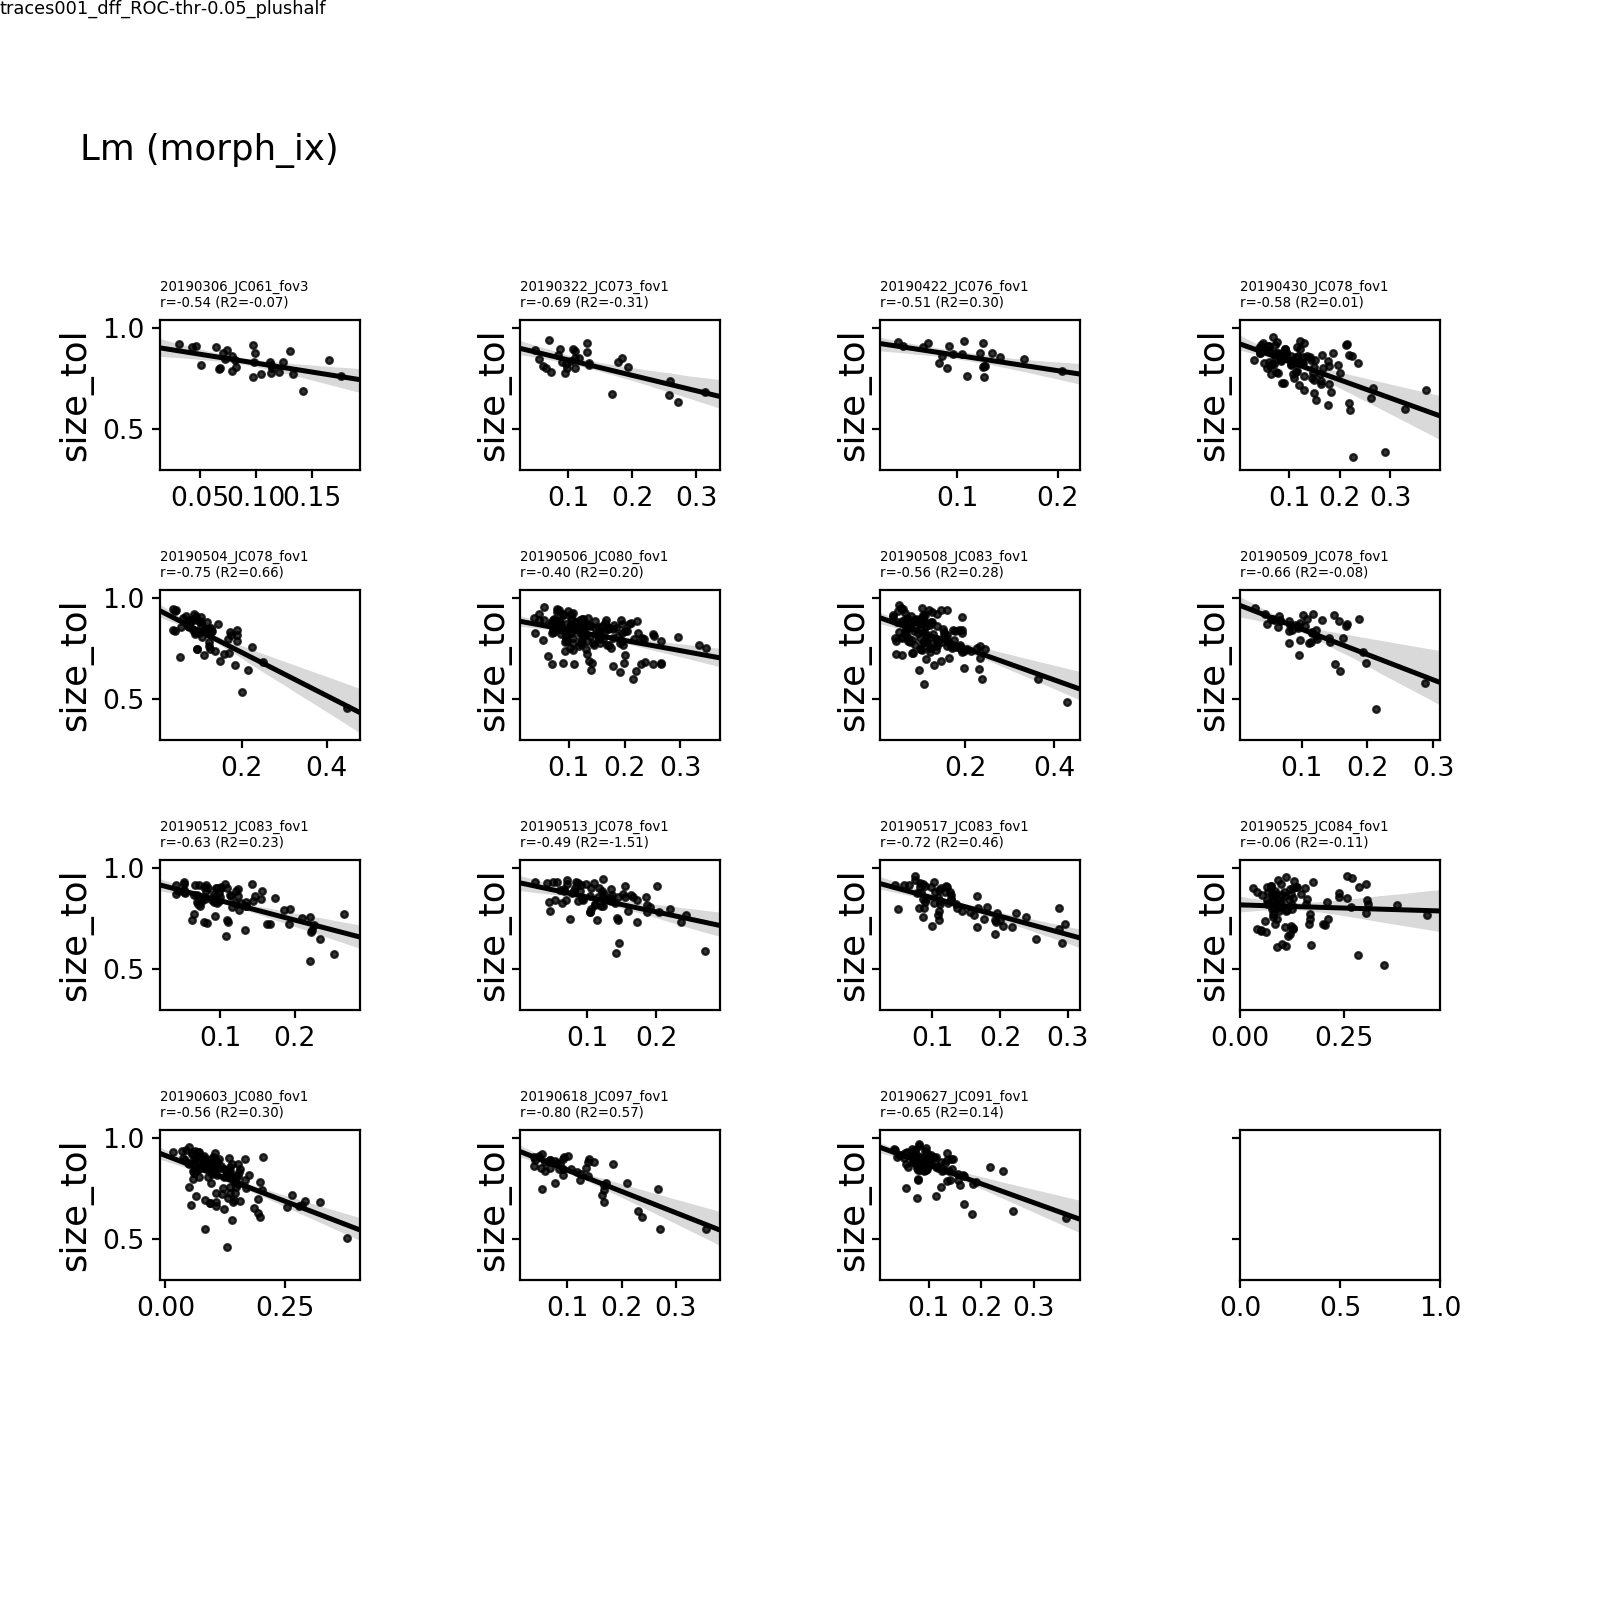

Bad fit: 20190306_JC061_fov3 (R2=-0.07)
Bad fit: 20190322_JC073_fov1 (R2=-0.31)
Bad fit: 20190509_JC078_fov1 (R2=-0.08)
Bad fit: 20190513_JC078_fov1 (R2=-1.51)
Bad fit: 20190525_JC084_fov1 (R2=-0.11)


<IPython.core.display.Javascript object>


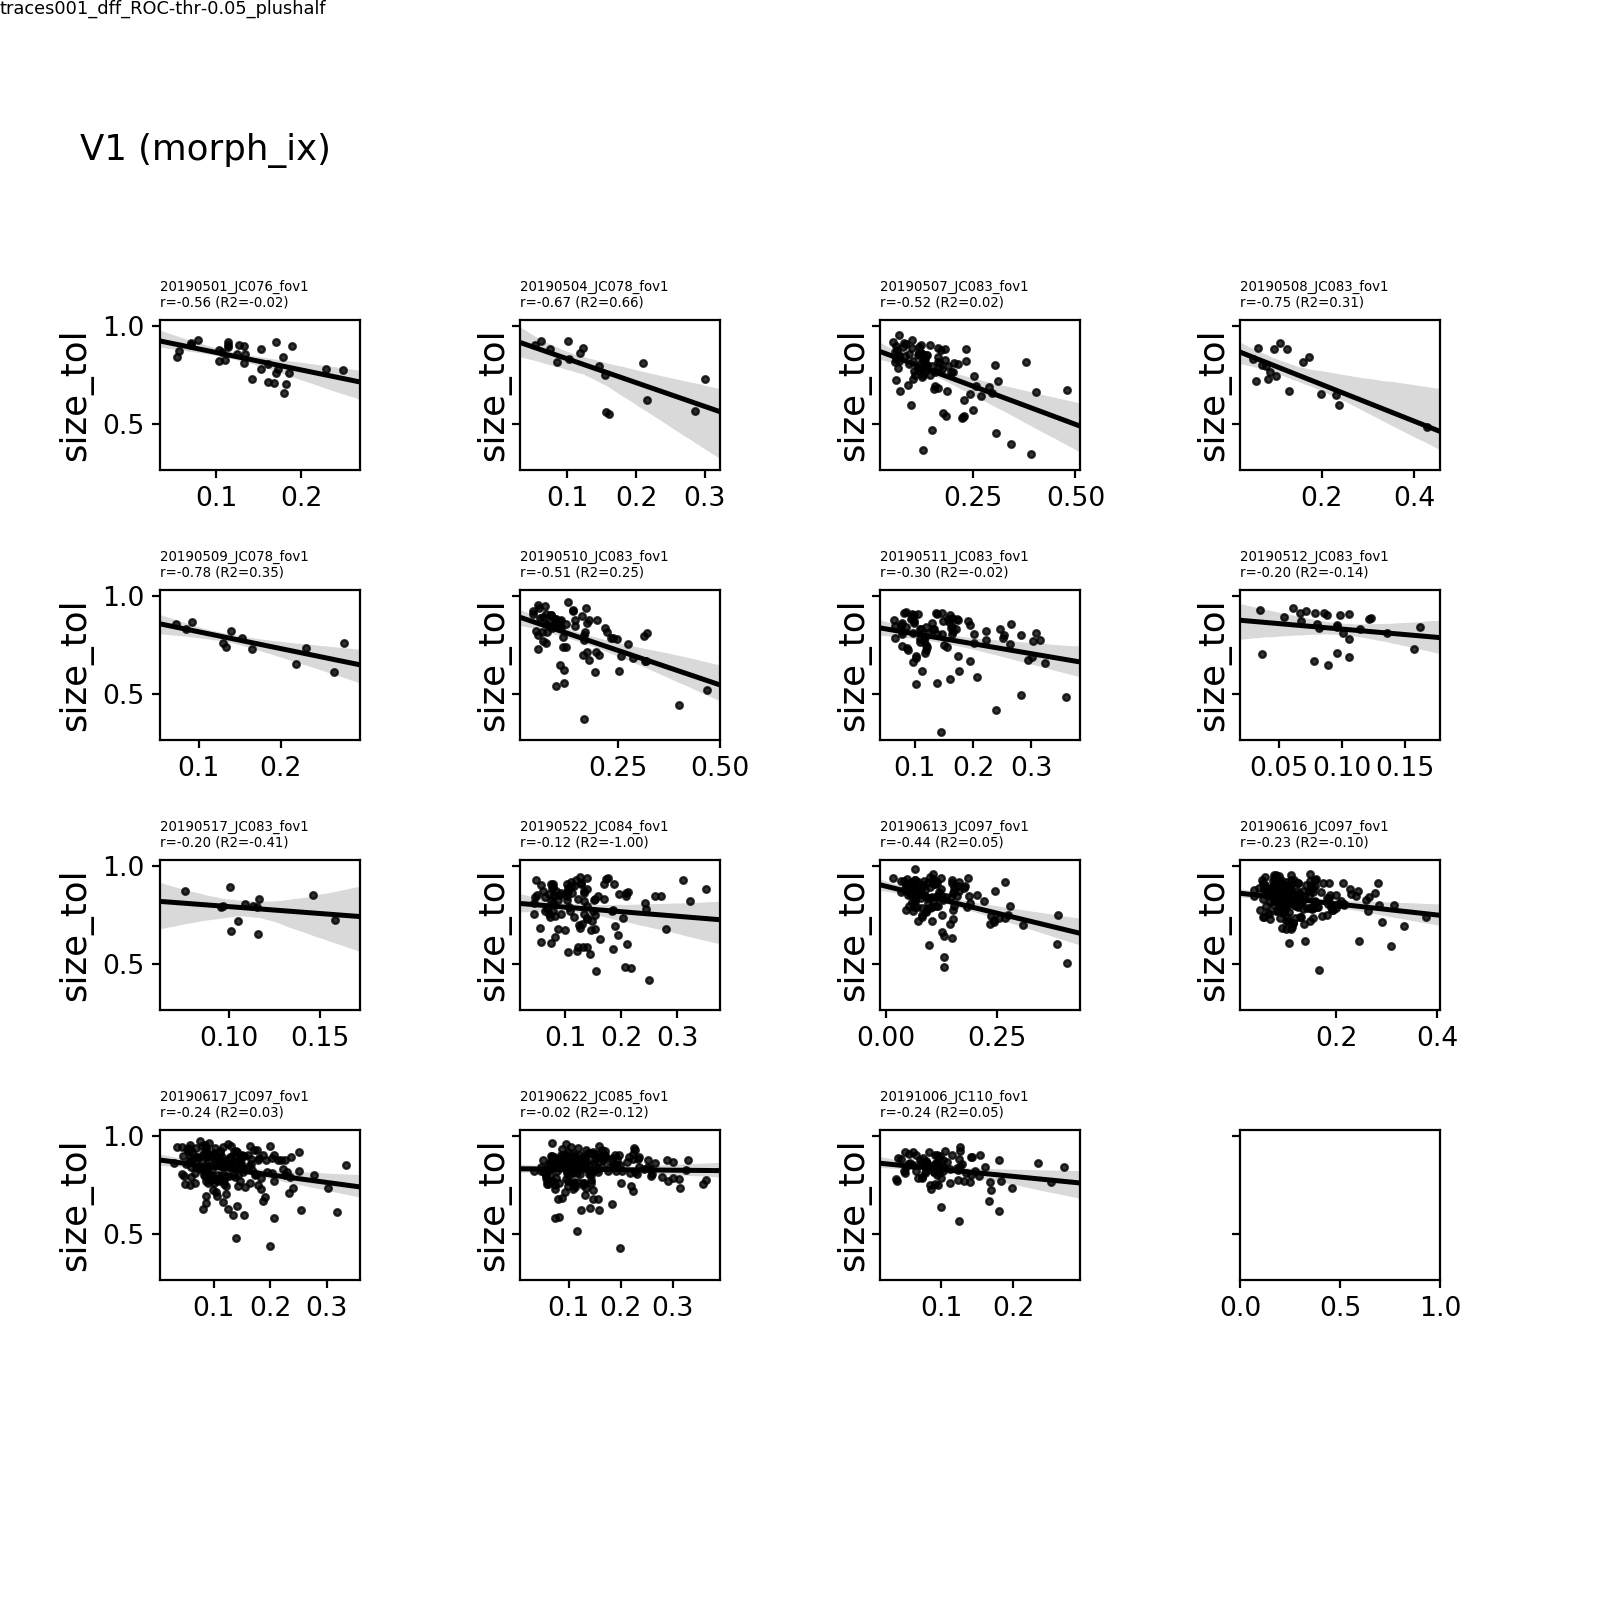

Bad fit: 20190501_JC076_fov1 (R2=-0.02)
Bad fit: 20190511_JC083_fov1 (R2=-0.02)
Bad fit: 20190512_JC083_fov1 (R2=-0.14)
Bad fit: 20190517_JC083_fov1 (R2=-0.41)
Bad fit: 20190522_JC084_fov1 (R2=-1.00)
Bad fit: 20190616_JC097_fov1 (R2=-0.10)
Bad fit: 20190622_JC085_fov1 (R2=-0.12)


MSE         R2       coef              datakey  intercept n_cells  \
0    1.99391  -0.660654   0.492129  20190315_JC070_fov1  -0.249694      27   
1    1.00293  -0.828283  -0.210237  20190322_JC073_fov1  -0.604327      38   
2    3.48606   -22.4452  -0.839103  20190327_JC073_fov1  -0.807067      27   
3   0.402154   0.127894  0.0249606  20190422_JC076_fov1  -0.872884      29   
4    1.32056  -0.236379   0.235879  20190602_JC091_fov1  -0.220633      87   
5   0.880273   0.133669  0.0383403  20190606_JC091_fov1  -0.149154      48   
6   0.595959   0.253503   0.047615  20190607_JC091_fov1  -0.323313      52   
7    1.35449 -0.0591767    0.13913  20190609_JC099_fov1 -0.0147996      57   
8   0.792256   0.342472   0.224402  20190612_JC099_fov1  -0.400628      38   
9    1.53637  0.0292508   0.243182  20190614_JC091_fov1  -0.195657      78   
10  0.995614   -2.42905  -0.440019  20191018_JC113_fov1  -0.185653      47   
11  0.531834 -0.0383747  -0.241116  20191105_JC117_fov1  -0.413152      67   
12   1.31125   -1.66029  -0.105562  20191111_JC120_fov1   -1.03256      30   

     pearsons_p  pearsons_r selectivity visual_area  
0      0.108021   -0.316263    morph_ix          Li  
1    0.00408482   -0.455195    morph_ix          Li  
2      0.961804 -0.00967393    morph_ix          Li  
3   2.31386e-07   -0.796839    morph_ix          Li  
4      0.471357  -0.0782345    morph_ix          Li  
5     0.0197577   -0.335468    morph_ix          Li  
6    0.00326816   -0.400406    morph_ix          Li  
7      0.976895 -0.00392295    morph_ix          Li  
8   2.06305e-05   -0.632232    morph_ix          Li  
9   4.55556e-07   -0.534827    morph_ix          Li  
10   0.00307284    -0.42275    morph_ix          Li  
11  0.000155634   -0.445929    morph_ix          Li  
12   0.00148188   -0.554276    morph_ix          Li

In [655]:
sel_type = 'morph_ix'

r_ = []
for visual_area, vg in passdf.groupby(['visual_area']):
    
    n_fovs = len(vg['datakey'].unique())

    fig, axn = pl.subplots(4, 4, figsize=(10, 10), sharex=False, sharey=True)
    for ax, (datakey, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):
        if len(ixs_) < min_ncells:
            ax.set_title('%s\n(n=%i cells)' % (datakey, len(ixs_)), loc='left', fontsize=6)
            
            continue
        #print(datakey, ixs_.shape)
        xx_ = ixs_[sel_type].values.reshape(-1, 1)
        yy_ = ixs_['size_tol'].values.reshape(-1, 1)
        
        xx = (xx_ - np.mean(xx_)) / np.std(xx_)
        yy = (yy_ - np.mean(yy_)) / np.std(yy_)
        X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.5, shuffle=False, random_state=20)

        # Fit OLS
        scaler  = preprocessing.StandardScaler().fit(X_train)
        x_train = scaler.transform(X_train)
        x_train = X_train.copy()
        regr = linear_model.LinearRegression().fit(x_train, y_train)
        x_test = scaler.transform(X_test)
        x_test = X_test.copy()
        y_pred = regr.predict(x_test)

        # metrics
        pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
        R2 = skmetrics.r2_score(y_test, y_pred)
        if R2<0:
            print("Bad fit: %s (R2=%.2f)" % (datakey, R2))
            #continue
            
        MSE = skmetrics.mean_squared_error(y_test, y_pred)
        B0 = float(regr.intercept_)
        B1 = float(regr.coef_)
        res = {'pearsons_r': float(pearsons_r), 'pearsons_p': float(pearsons_p), 'R2': R2, 'MSE': MSE, 
               'coef': B0, 'intercept': B1, 'selectivity': sel_type,
               'visual_area': visual_area, 'datakey': datakey, 'n_cells': len(xx)}
        # plot
        #ax.scatter(xx, yy, color='k', marker='.', s=2)
        sns.regplot(sel_type, 'size_tol', data=ixs_, color='k', marker='.', ax=ax) #, size=2)\
        lc = 'r' if R2>0.5 else 'k'
        ax.set_xlabel('')
#         ax.plot(x_test, y_pred, color=lc)
            
#         xmin, xmax = ax.get_xlim()
#         xvs = np.linspace(xmin, xmax, num=5)
    
#         ax.plot(xvs, B0 + B1*xvs, c=lc, alpha=0.5)
        ax.set_title('%s\nr=%.2f (R2=%.2f)' % (datakey, pearsons_r, R2), loc='left', fontsize=6)
        
        r_.append(pd.Series(res))
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    fig.text(0.05, 0.9, '%s (%s)' % (visual_area, sel_type), fontsize=16)
    putils.label_figure(fig, data_id)
    pl.savefig(os.path.join(dst_dir, 'correlations_%s_dsets.png' % visual_area))

regressiondf = pd.concat(r_, axis=1).T #reset_index(drop=True)
regressiondf[regressiondf.visual_area=='Li']

In [178]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance'

<IPython.core.display.Javascript object>


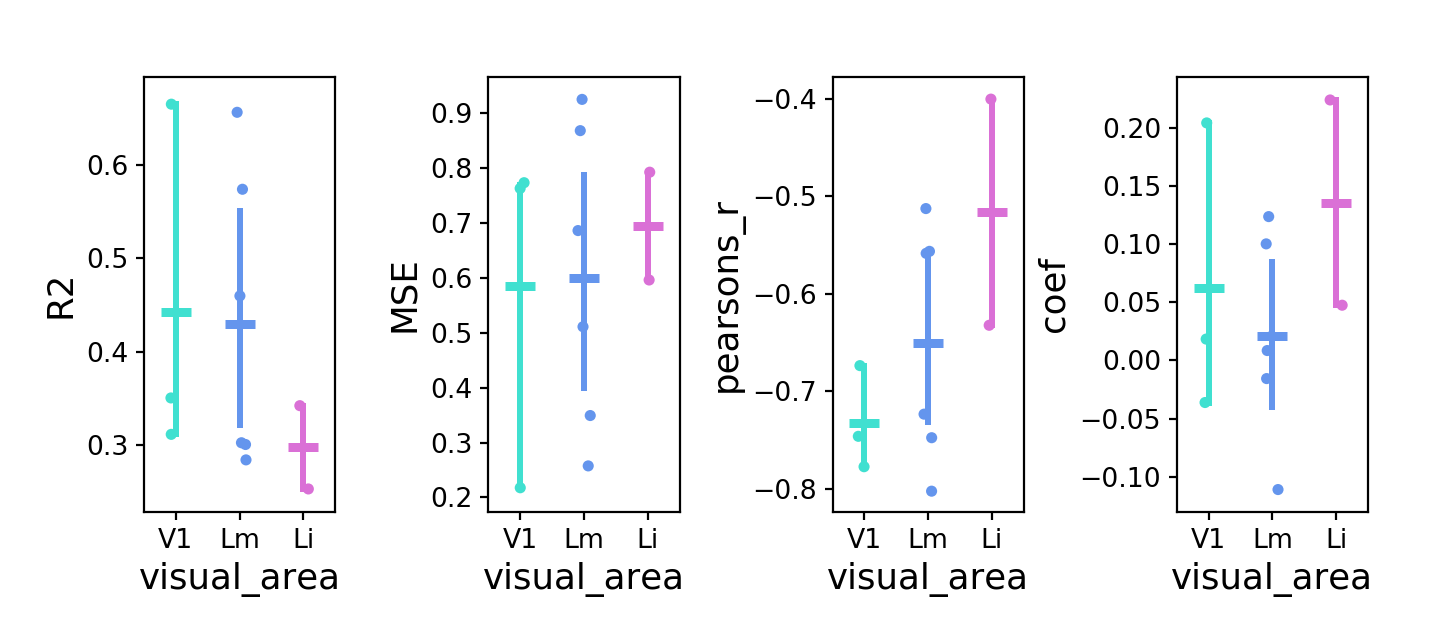

In [656]:
plot_params = ['R2', 'MSE', 'pearsons_r', 'coef']
fig, axn = pl.subplots(1, len(plot_params), figsize=(9, 4))
for ax, p in zip(axn.flat, plot_params):
    sns.stripplot(x='visual_area', y=p, data=regressiondf[regressiondf['R2']>=0.25], ax=ax, 
                 order=visual_areas, hue='visual_area', palette=area_colors)
    sns.pointplot(x='visual_area', y=p, data=regressiondf[regressiondf['R2']>=0.25], ax=ax, 
                 order=visual_areas, hue='visual_area', palette=area_colors,
                 markers='_', scale=2, join=False)
    ax.legend_.remove()

pl.subplots_adjust(left=0.1, right=0.95, wspace=0.8, bottom=0.2)

In [ ]:
'20190422_JC076_fov1'


In [657]:


visual_area='Li'
datakey = '20190422_JC076_fov1'
sel_type = 'morph_ix'

ixs_ = passdf[(passdf.visual_area==visual_area) & (passdf.datakey==datakey)].copy()

xx = ixs_[sel_type].values
yy = ixs_['size_tol'].values

pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)

n_iters=1000
n_cells = len(xx)
ixdf = pd.DataFrame({'xx': xx, 'yy': yy})

shuff = np.concatenate((xx, yy))

s_=[]
b_=[]
for i in np.arange(0, n_iters):
    
#     np.random.shuffle(xx)
#     np.random.shuffle(yy)
    resample_ = ixs_.sample(n=n_cells, replace=True)
    xx = resample_[sel_type].values
    yy = resample_['size_tol'].values
    boot_r, boot_p = spstats.pearsonr(xx, yy)
    b_.append((boot_r, boot_p))
    
    np.random.shuffle(xx)
    np.random.shuffle(yy)
    shuff_r, shuff_p = spstats.pearsonr(xx, yy)
    s_.append((shuff_r, shuff_p))
    

shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
boot_results = pd.DataFrame(b_, columns=['r', 'p'])

p_val = shuff_results[shuff_results['r']<pearsons_r].shape[0]/float(n_iters)


<IPython.core.display.Javascript object>


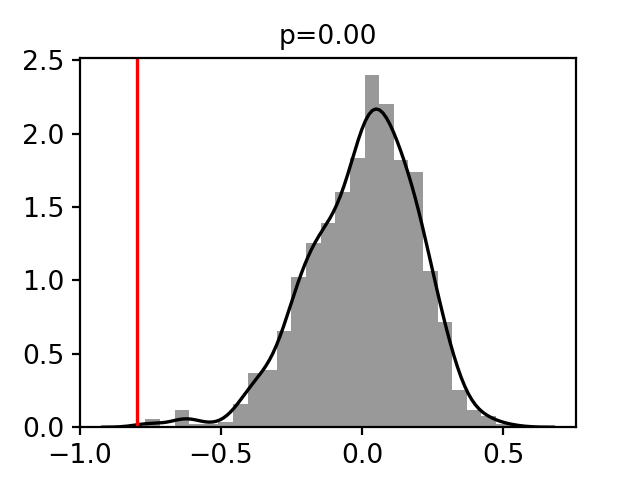

In [658]:
fig, ax = pl.subplots(figsize=(4,3))
ax.set_title('p=%.2f' % p_val)
sns.distplot(shuff_results['r'], color='k')
ax.axvline(x=pearsons_r, color='r')

# lo, hi = putils.get_empirical_ci(boot_results['r'])
# sns.distplot(boot_results['r'], color='b')
# ax.axvline(x=lo, linestyle=':', c='b')
# ax.axvline(x=hi, linestyle=':', c='b')


In [42]:
'20190422_JC076_fov1' in xdf['datakey'].unique()

True

In [659]:
curr_df = pd.concat([g for (v, k), g in xdf.groupby(['visual_area', 'datakey']) \
                    if (len(g['cell'].unique())>=min_ncells) & (k not in excl_dsets)])


In [660]:
n_iters=5000

sel_type = 'morph_ix'
r_ = []
for (visual_area, datakey), ixs_ in curr_df.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    xx = ixs_[sel_type].values
    yy = ixs_['size_tol'].values

    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)

    n_points = len(xx)
    shuff = np.concatenate((xx, yy))

    s_=[]
    for i in np.arange(0, n_iters):
        np.random.shuffle(xx)
        np.random.shuffle(yy)
        shuff_r, shuff_p = spstats.pearsonr(xx, yy)
        s_.append((shuff_r, shuff_p))

    shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
    p_val = shuff_results[shuff_results['r']<pearsons_r].shape[0]/float(n_iters)
    
    r_.append((visual_area, datakey, p_val, pearsons_r, n_points))

resdf = pd.DataFrame(r_, columns=['visual_area', 'datakey', 'p_val', 'pearsons_r', 'n_cells'])


print(resdf.shape)
print(resdf[resdf['p_val']<0.05].shape)


(26, 5)
(19, 5)


In [661]:
print(resdf.shape)
print(resdf[resdf['p_val']<0.001].shape)


(26, 5)
(13, 5)


<IPython.core.display.Javascript object>


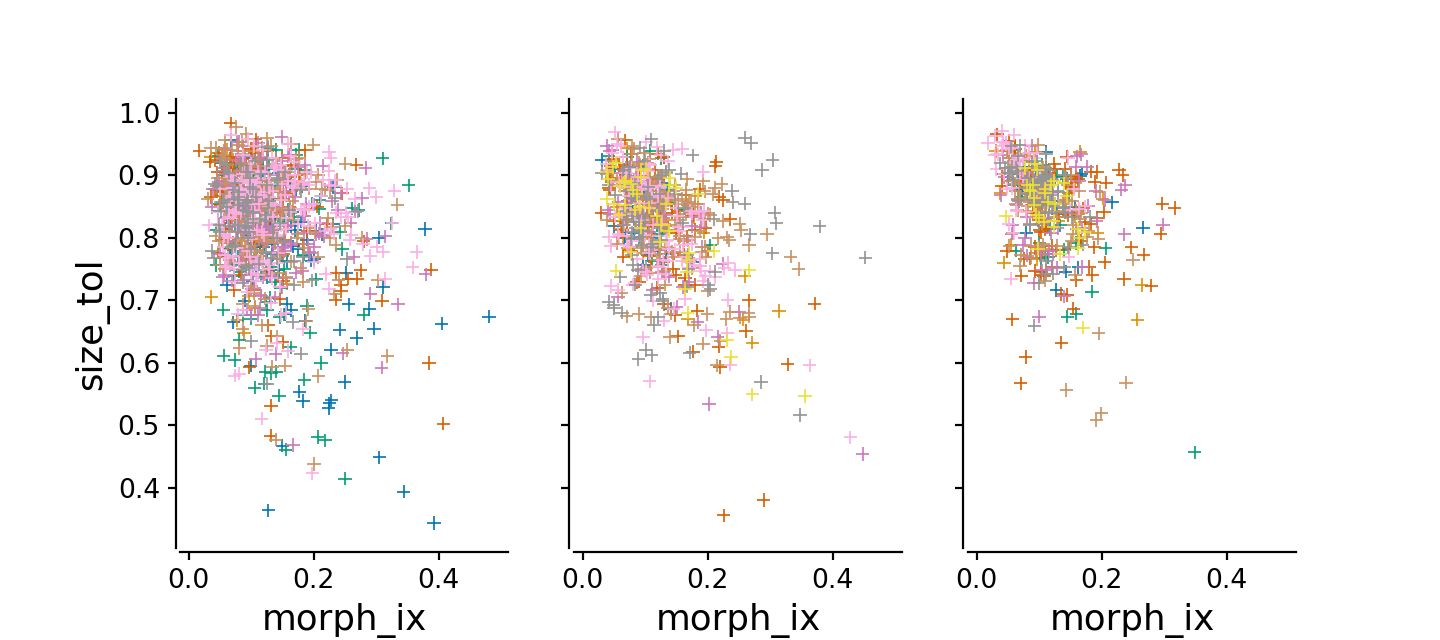

In [662]:
ymin, ymax = curr_df['size_tol'].min(), curr_df['size_tol'].max()
xmin, xmax = curr_df[sel_type].min(), curr_df[sel_type].max()
xlim = ymax-ymin

fig, axn = pl.subplots(1,3,figsize=(9,4), sharex=True, sharey=True)
for va, vg in curr_df.groupby(['visual_area']): #, 'datakey']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    
    sns.scatterplot(x=sel_type, y='size_tol', data=vg, ax=ax,
                   hue='datakey', palette='colorblind', marker='+')
    ax.legend_.remove()
    
for ax in axn.flat:
    #ax.set_xlim([0, 0.5])
    #ax.set_ylim([0.5, 1])
    ax.set(adjustable='box-forced', aspect='equal')
    sns.despine(offset=2)

In [664]:
resdf[resdf['p_val']<p_thr][['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Lm    8
Li    6
V1    5
Name: visual_area, dtype: int64

                p_val  pearsons_r     n_cells
visual_area                                  
Li           0.001667   -0.534969   48.166667
Lm           0.000725   -0.604507   69.375000
V1           0.003440   -0.333448  132.800000


<IPython.core.display.Javascript object>


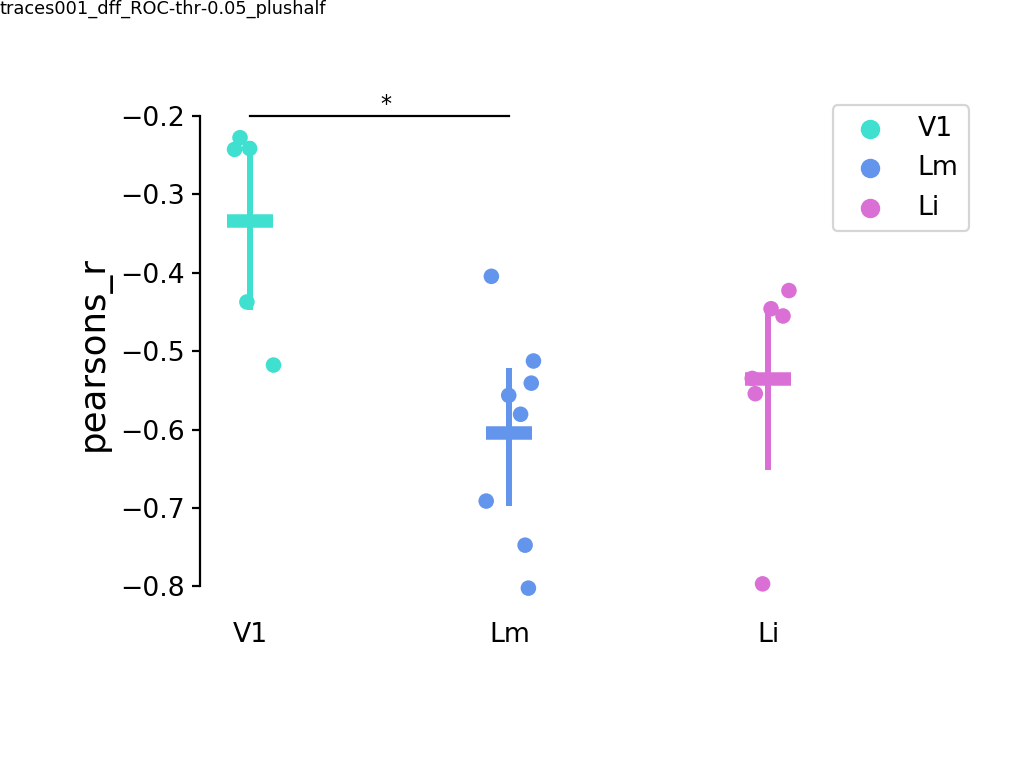

********* [pearsons_r] Mann-Whitney U test(mc=bonferroni) **********
   U_val  d1  d2  n1  n2     p_val  reject
0    3.0  V1  Lm   5   8  0.023580    True
1    4.0  V1  Li   5   6  0.082851   False
2   15.0  Lm  Li   8   6  0.408736   False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance', 'corrcoef_pass-boot-0.050_bonferroni__drop_repeats_most_cells')


In [665]:
multi_comp_test='bonferroni'
p_thr=0.05 #0.001 #01

pcorrdf = resdf[resdf['p_val']<p_thr].copy()
print(pcorrdf.groupby(['visual_area']).mean())

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='pearsons_r', data=pcorrdf, ax=ax,
              hue='visual_area', palette=area_colors, size=7,
              order=visual_areas, hue_order=visual_areas)
sns.pointplot(x='visual_area', y='pearsons_r', data=pcorrdf, ax=ax,
              hue='visual_area', palette=area_colors, markers='_', scale=3, join=False,
             order=visual_areas, hue_order=visual_areas)

y_loc=-0.2
offset=0.05
statresults, ax = aggr.plot_mannwhitney(pcorrdf, metric='pearsons_r', ax=ax, 
                                multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)


#aggr.do_mannwhitney(pcorrdf, metric='pearsons_r', multi_comp_test=multi_comp_test)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1, 1), loc='upper left')

sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2)
ax.set_xlabel('')

putils.label_figure(fig, data_id)
figname = 'corrcoef_pass-boot-%.3f_%s__%s' %(p_thr, multi_comp_test, dset_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [188]:
pcorrdf

visual_area              datakey   p_val  pearsons_r  n_cells
0           Li  20190315_JC070_fov1  0.0006   -0.662868       27
1           Li  20190322_JC073_fov1  0.0000   -0.740894       38
2           Li  20190422_JC076_fov1  0.0000   -0.780281       29
3           Li  20190602_JC091_fov1  0.0028   -0.299718       87
5           Li  20190614_JC091_fov1  0.0000   -0.685576       78
6           Li  20191018_JC113_fov1  0.0000   -0.655443       47
7           Li  20191105_JC117_fov1  0.0000   -0.729736       67
8           Li  20191111_JC120_fov1  0.0000   -0.788020       30
9           Lm  20190306_JC061_fov3  0.0000   -0.769249       30
10          Lm  20190322_JC073_fov1  0.0004   -0.682136       30
11          Lm  20190422_JC076_fov1  0.0062   -0.515509       22
12          Lm  20190430_JC078_fov1  0.0000   -0.667566       98
13          Lm  20190504_JC078_fov1  0.0000   -0.749066       59
14          Lm  20190506_JC080_fov1  0.0000   -0.631474      147
15          Lm  20190508_JC083_fov1  0.0000   -0.730656      125
16          Lm  20190525_JC084_fov1  0.0140   -0.235494       91
17          Lm  20190618_JC097_fov1  0.0000   -0.745967       44
18          V1  20190507_JC083_fov1  0.0000   -0.597138       97
19          V1  20190512_JC083_fov1  0.0092   -0.472380       28
20          V1  20190522_JC084_fov1  0.0002   -0.389978      107
21          V1  20190613_JC097_fov1  0.0000   -0.550912      120
22          V1  20190616_JC097_fov1  0.0000   -0.555729      184
23          V1  20190617_JC097_fov1  0.0000   -0.441162      177
24          V1  20190622_JC085_fov1  0.0000   -0.531146      196
25          V1  20191006_JC110_fov1  0.0000   -0.553101       86

In [189]:
NDATA[(NDATA.datakey.isin(pcorrdf['datakey'].values)) & (NDATA['response']>=1.2) & (NDATA['visual_area']=='Li')]

visual_area              datakey     config  trial cell  response
29838           Li  20191018_JC113_fov1  config050   1339  176  1.219324
74761           Li  20191018_JC113_fov1  config048    662   88  1.407003
76892           Li  20191018_JC113_fov1  config007   2793   88  1.592115
111360          Li  20191018_JC113_fov1  config010    211  114  1.231151
112516          Li  20191018_JC113_fov1  config043   1367  114  1.447022
112977          Li  20191018_JC113_fov1  config027   1828  114  1.309180
113457          Li  20191018_JC113_fov1  config021   2308  114  1.239304
113458          Li  20191018_JC113_fov1  config005   2309  114  1.391556
113459          Li  20191018_JC113_fov1  config017   2310  114  1.413737
691             Li  20190602_JC091_fov1  config040    692   13  1.236816
13298           Li  20190602_JC091_fov1  config012   1307   28  1.254424
30601           Li  20190602_JC091_fov1  config042    622   44  2.068812
30691           Li  20190602_JC091_fov1  config034    712   44  1.338501
30692           Li  20190602_JC091_fov1  config037    713   44  1.454307
30734           Li  20190602_JC091_fov1  config040    755   44  1.326000
30753           Li  20190602_JC091_fov1  config004    774   44  1.308646
30771           Li  20190602_JC091_fov1  config001    792   44  2.198587
30772           Li  20190602_JC091_fov1  config028    793   44  1.840042
30803           Li  20190602_JC091_fov1  config001    824   44  2.210161
30868           Li  20190602_JC091_fov1  config031    889   44  1.434992
30869           Li  20190602_JC091_fov1  config003    890   44  1.316237
30893           Li  20190602_JC091_fov1  config007    914   44  2.418515
30894           Li  20190602_JC091_fov1  config025    915   44  1.236698
30898           Li  20190602_JC091_fov1  config001    919   44  1.693188
30899           Li  20190602_JC091_fov1  config030    920   44  1.281651
30929           Li  20190602_JC091_fov1  config049    950   44  2.290340
30935           Li  20190602_JC091_fov1  config048    956   44  1.937653
30946           Li  20190602_JC091_fov1  config012    967   44  1.318341
30965           Li  20190602_JC091_fov1  config025    986   44  1.333380
30967           Li  20190602_JC091_fov1  config002    988   44  2.935206
...            ...                  ...        ...    ...  ...       ...
35992           Li  20191111_JC120_fov1  config006   1493  113  2.999159
35993           Li  20191111_JC120_fov1  config039   1494  113  3.127137
35994           Li  20191111_JC120_fov1  config023   1495  113  3.461925
35995           Li  20191111_JC120_fov1  config019   1496  113  2.398068
35996           Li  20191111_JC120_fov1  config027   1497  113  2.580070
35997           Li  20191111_JC120_fov1  config016   1498  113  2.357485
35998           Li  20191111_JC120_fov1  config004   1499  113  1.694338
35999           Li  20191111_JC120_fov1  config007   1500  113  2.829081
141             Li  20190422_JC076_fov1  config016    142   76  1.393773
142             Li  20190422_JC076_fov1  config042    143   76  1.349774
259             Li  20190422_JC076_fov1  config011    260   76  1.576238
888             Li  20190422_JC076_fov1  config001    889   76  1.470756
933             Li  20190422_JC076_fov1  config039    934   76  1.317835
971             Li  20190422_JC076_fov1  config036    972   76  1.870293
1005            Li  20190422_JC076_fov1  config048   1006   76  1.314624
1028            Li  20190422_JC076_fov1  config032   1029   76  1.341764
1079            Li  20190422_JC076_fov1  config022   1080   76  1.437025
1192            Li  20190422_JC076_fov1  config041   1193   76  1.812881
1212            Li  20190422_JC076_fov1  config006   1213   76  1.336409
24351           Li  20190422_JC076_fov1  config008    352  284  1.215498
25192           Li  20190422_JC076_fov1  config041   1193  284  1.250592
36004           Li  20190422_JC076_fov1  config014      5  309  1.919379
36142           Li  20190422_JC076_fov1  config042    143  309  1

In [50]:
resdf[resdf['p_val']<p_thr]

visual_area              datakey   p_val  pearsons_r  n_cells
0           Li  20190315_JC070_fov1  0.0010   -0.662868       27
1           Li  20190322_JC073_fov1  0.0000   -0.740894       38
2           Li  20190422_JC076_fov1  0.0000   -0.780281       29
3           Li  20190602_JC091_fov1  0.0038   -0.299718       87
5           Li  20190614_JC091_fov1  0.0000   -0.685576       78
6           Li  20191018_JC113_fov1  0.0000   -0.655443       47
7           Li  20191111_JC120_fov1  0.0000   -0.788020       30
8           Lm  20190306_JC061_fov3  0.0000   -0.769249       30
9           Lm  20190322_JC073_fov1  0.0000   -0.682136       30
10          Lm  20190422_JC076_fov1  0.0078   -0.515509       22
11          Lm  20190430_JC078_fov1  0.0000   -0.667566       98
12          Lm  20190504_JC078_fov1  0.0000   -0.749066       59
13          Lm  20190506_JC080_fov1  0.0000   -0.631474      147
14          Lm  20190508_JC083_fov1  0.0000   -0.730656      125
15          Lm  20190525_JC084_fov1  0.0164   -0.235494       91
16          Lm  20190618_JC097_fov1  0.0000   -0.745967       44
17          V1  20190507_JC083_fov1  0.0000   -0.597138       97
18          V1  20190512_JC083_fov1  0.0100   -0.472380       28
19          V1  20190522_JC084_fov1  0.0000   -0.389978      107
20          V1  20190613_JC097_fov1  0.0000   -0.550912      120
21          V1  20190616_JC097_fov1  0.0000   -0.555729      184
22          V1  20190617_JC097_fov1  0.0000   -0.441162      177
23          V1  20190622_JC085_fov1  0.0000   -0.531146      196
24          V1  20191006_JC110_fov1  0.0000   -0.553101       86

<IPython.core.display.Javascript object>


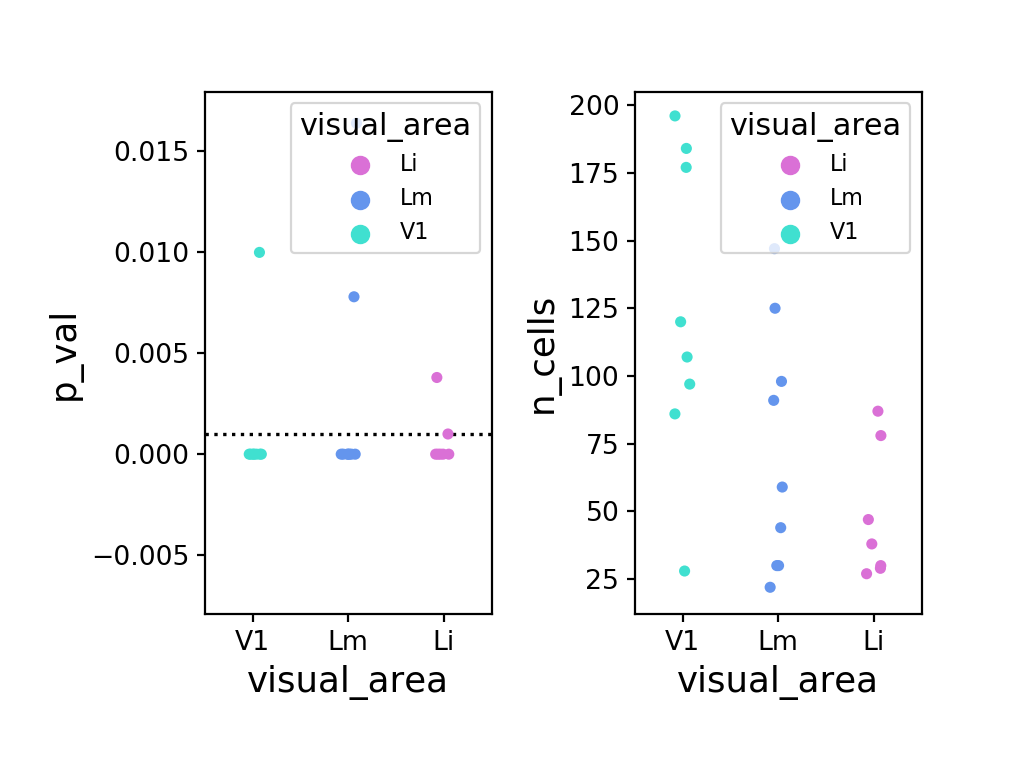

In [49]:

fig, axn = pl.subplots(1,2)

ax=axn[0]
sns.stripplot(x='visual_area', y='p_val', data=pcorrdf,  ax=ax, 
              hue='visual_area', palette=area_colors, order=visual_areas)
ax.axhline(y=0.001, linestyle=':', color='k')

ax=axn[1]
sns.stripplot(x='visual_area', y='n_cells', data=pcorrdf, ax=ax, 
              hue='visual_area', palette=area_colors, order=visual_areas)


pl.subplots_adjust(left=0.2, right=0.9, wspace=0.5, bottom=0.2)


In [1292]:
NDATA[(NDATA.visual_area=='V1') & (NDATA.datakey=='20190510_JC083_fov1')]['response'].min()

-0.40334947782439934

In [1293]:
print(NDATA.groupby(['visual_area'])['response'].min())

print(NDATA.groupby(['visual_area'])['response'].max())


visual_area
Li   -0.488944
Lm   -0.414147
V1   -0.556200
Name: response, dtype: float64
visual_area
Li    2.750405
Lm    3.866704
V1    4.968845
Name: response, dtype: float64


# Test dff calculations

In [17]:
animalid = 'JC083'
session = '20190510'
fov = 'FOV1_zoom2p0x'
datakey='%s_%s_fov1' % (session, animalid)
visual_area='V1'

In [18]:
glob.glob(os.path.join(rootdir, animalid, session, fov,
                                '*%s_static' % (experiment), 'traces', '%s*' % traceid,
                                'data_arrays', '*.npz'))

['/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/datasets.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/labels.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/neuropil.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz',
 '/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_t

In [55]:
def load_corrected_dff_traces(animalid, session, fov, experiment='blobs', traceid='traces001',
                              return_traces=True, epoch='stimulus', metric='mean', 
                              rootdir='/n/coxfs01/2p-data'):
    # Load corrected
    soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov,
                                    '*%s_static' % (experiment), 'traces', '%s*' % traceid,
                                    'data_arrays', 'np_subtracted.npz'))[0]
    dset = np.load(soma_fpath)
    Fc = pd.DataFrame(dset['data']) # np_subtracted:  Np-corrected trace, with baseline subtracted

    # Load raw (pre-neuropil subtraction)
    raw = np.load(soma_fpath.replace('np_subtracted', 'raw'))
    F0_raw = pd.DataFrame(raw['f0'])

    # Calculate df/f
    dff = Fc.divide(F0_raw) # dff 

    if return_traces:
        return dff
    else:
        labels = pd.DataFrame(data=dset['labels_data'],columns=dset['labels_columns'])
        dfmat = aggr.traces_to_trials(dff, labels, epoch=epoch, metric=metric)
        return dfmat

In [19]:
soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov,
                                '*%s_static' % (experiment), 'traces', '%s*' % traceid,
                                'data_arrays', 'np_subtracted.npz'))[0]
soma_fpath

'/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz'

In [20]:
dset = np.load(soma_fpath)
dset.keys()


['f0',
 'labels_columns',
 'sconfigs',
 'file_ixs',
 'run_info',
 'labels_data',
 'data']

In [21]:
dset['data'].shape

(236250, 192)

In [22]:
dset['data'].min(), dset['data'].max()

(-1650.736078181193, 10082.88675394144)

In [23]:
dset['f0'].min(), dset['f0'].max(),  dset['f0'].mean()

(-189.8199491232108, 7448.278411045068, 60.58968248816426)

In [32]:
raw = np.load(soma_fpath.replace('np_subtracted', 'raw'))
raw.keys()

['f0',
 'labels_columns',
 'sconfigs',
 'file_ixs',
 'run_info',
 'labels_data',
 'data']

In [27]:
print(raw['f0'].min(), raw['f0'].max(),  raw['f0'].mean())
print(raw['data'].min(), raw['data'].max(),  raw['data'].mean())

(6.560815429687501, 8030.35705180921, 376.8797332209979)
(-1644.0365645559223, 10133.190476190475, 85.76374606879699)


In [30]:
F0_raw = pd.DataFrame(raw['f0'])

In [42]:
dset2 = np.load(soma_fpath.replace('np_subtracted', 'dff'))
print(dset2.keys())

dff = pd.DataFrame(dset2['data'])

['data']


In [40]:
Fc = pd.DataFrame(dset['data']) #.copy() # np_subtracted:  Np-corrected trace, with baseline subtracted

# test = (Fc+F0_raw.mean(axis=0)).divide(F0_raw)
test = Fc.divide(F0_raw)
test.shape


(236250, 192)

<IPython.core.display.Javascript object>


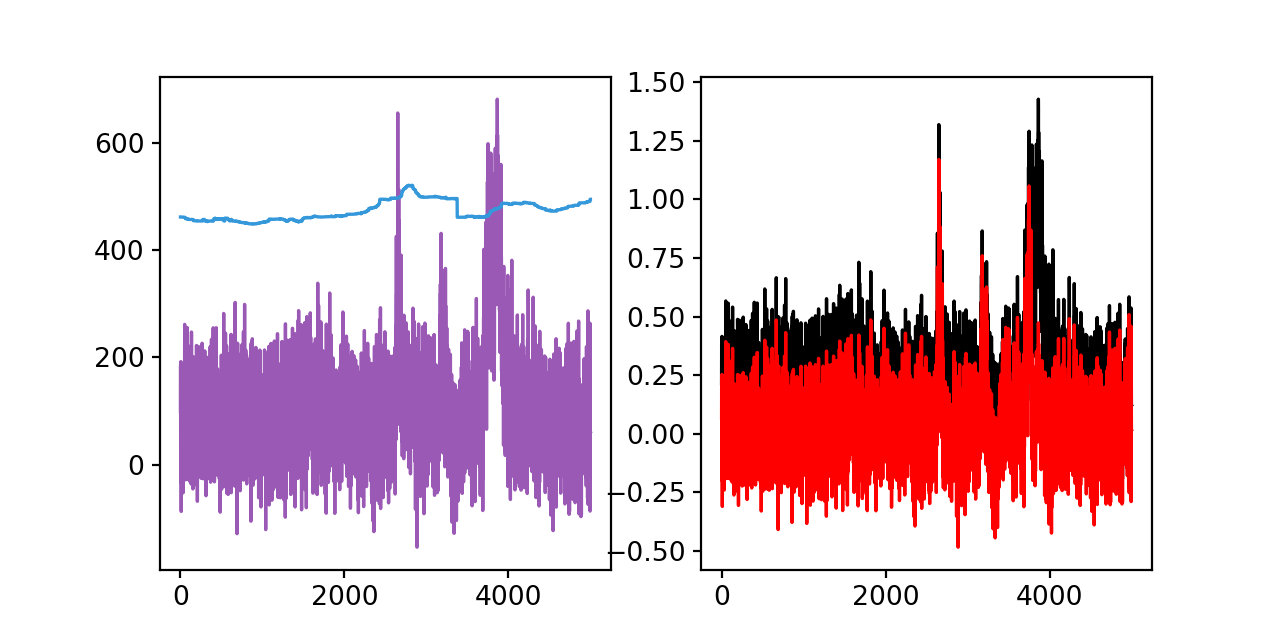

In [43]:

fig, axn = pl.subplots(1,2, figsize=(8,4))
ax=axn[0]
ax.plot(Fc[23].loc[0:5000])
ax.plot(F0_raw[23].loc[0:5000])

ax=axn[1]
ax.plot(test[23].loc[0:5000], 'k')

ax.plot(dff[23].loc[0:5000], 'r')

In [47]:
labels = pd.DataFrame(data=dset['labels_data'],columns=dset['labels_columns'])

In [48]:
dfmat = aggr.traces_to_trials(test, labels, epoch='plushalf', metric='mean')


In [50]:
sdf = SDF[datakey].copy()
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
ndf = aggr.unstacked_neuraldf_to_stacked(dfmat)

In [51]:
ix1 = calculate_indices_for_neuraldf(x0, sdf, images_only=True)
ix2 = calculate_indices_for_neuraldf(ndf, sdf, images_only=True)

<IPython.core.display.Javascript object>


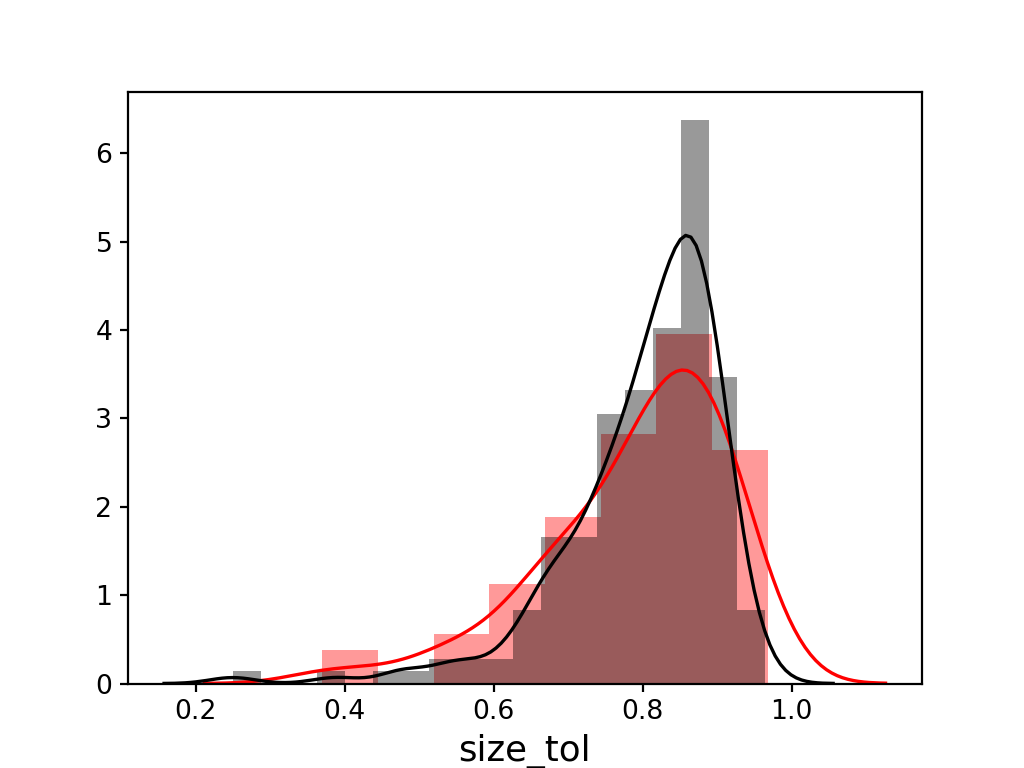

In [54]:
fig, ax = pl.subplots()
sns.distplot(ix1['size_tol'], color='r')
sns.distplot(ix2['size_tol'], color='k')

In [723]:
def to_uint16(values):
    offset = 32768
    tmp = np.zeros(values.shape, dtype='uint16')
    tmp[:] = values + offset
    
    return tmp.astype(float)

In [724]:
tmp = dset['data'].copy()
fmp = dset['f0'].copy()


In [748]:
dset['data'].columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [725]:
tmp = to_uint16(tmp)
fmp = to_uint16(fmp)


In [739]:
test = tmp/fmp


In [740]:
test.min(), test.max()

(0.7801123930773821, 1.2435789534782482)

In [759]:
traces = pd.DataFrame(test, columns=np.arange(0, test.shape[1]))
traces.shape

(236250, 192)

In [760]:
test_df = aggr.traces_to_trials(traces, labels, epoch='plushalf', metric='mean')
test_df.head()

0         1         2         3         4         5         6  \
1  0.999610  1.000025  0.999316  0.991719  1.001486  1.001180  1.001287   
2  1.000796  1.001097  0.999683  0.996914  1.003384  1.001796  1.001244   
3  0.999890  1.000400  0.999721  0.995738  1.001926  1.001097  1.000830   
4  0.999753  1.000238  0.999247  0.994379  1.001366  1.001419  1.000617   
5  0.999972  1.000406  0.999492  0.998747  1.001866  1.000859  1.001328   

          7         8         9    ...           183       184       185  \
1  1.001714  0.996785  1.000335    ...      1.002620  1.001117  1.003343   
2  1.002149  0.997750  1.000364    ...      1.002684  1.001822  1.003051   
3  1.001573  0.996286  1.000135    ...      1.003355  1.001246  1.002332   
4  1.001255  0.996942  1.000013    ...      1.002552  1.002160  1.002642   
5  1.001345  0.997456  0.999893    ...      1.002358  1.001084  1.004265   

        186       187       188       189       190       191     config  
1  1.003840  0.998837  1.001194  1.003304  1.002089  1.002646  config002  
2  1.003657  0.997668  1.002799  1.003001  1.002454  1.002540  config046  
3  1.003878  0.997793  1.002885  1.002838  1.002539  1.002780  config026  
4  1.003692  0.998505  1.002552  1.003257  1.002518  1.002688  config001  
5  1.004001  0.998400  1.002117  1.003425  1.002348  1.002710  config036  

[5 rows x 193 columns]

In [783]:
datakey

'20190510_JC083_fov1'

In [784]:
neuraldf = MEANS[datakey].copy()
neuraldf.head()

0         2         4         5         6         7         9  \
1 -0.010698  0.000123  0.006529  0.031195  0.005798  0.051103  0.006072   
2 -0.010856  0.024922  0.124030  0.049847  0.034085  0.057988  0.018136   
3  0.000594  0.012877 -0.001856 -0.017591  0.040185  0.015279 -0.000661   
4 -0.000391 -0.014903 -0.019628  0.034836  0.001580  0.006920  0.011577   
5  0.016573  0.012088  0.039259  0.004932  0.016834  0.037692  0.003096   

         12        14        15    ...           173       174       175  \
1  0.014318  0.048286  0.048130    ...     -0.003894  0.020267  0.045351   
2  0.026162 -0.028213 -0.005115    ...     -0.031167 -0.002087  0.055682   
3 -0.028741 -0.048179  0.034056    ...     -0.014853  0.031705  0.054109   
4  0.006286  0.037214  0.013120    ...     -0.016611  0.008855 -0.030890   
5  0.044437  0.014690  0.029074    ...      0.002015 -0.061377  0.042023   

        178       179       183       184       187       191     config  
1  0.010913  0.001636  0.029439  0.015976  0.058155  0.014011  config002  
2  0.039179 -0.003219  0.027370  0.043687  0.010137  0.001492  config046  
3  0.007082  0.011828  0.053046  0.032383 -0.054882  0.012544  config026  
4 -0.027983  0.000393 -0.000273  0.009370  0.035817 -0.013513  config001  
5 -0.011192  0.018273  0.003700 -0.008959  0.052858  0.017178  config036  

[5 rows x 76 columns]

In [791]:
rois_ = [int(r) for r in neuraldf.columns if putils.isnumber(r)]
n = test_df[rois_].copy()
n['config'] = test_df['config']
ndf = aggr.unstacked_neuraldf_to_stacked(n)
ndf.shape

(131250, 4)

In [794]:
ndf.head()

config  trial cell  response
0  config002      1    0  0.999610
1  config046      2    0  1.000796
2  config026      3    0  0.999890
3  config001      4    0  0.999753
4  config036      5    0  0.999972

In [793]:
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[datakey].copy() #aggr.get_master_sdf()
x0.head()


visual_area              datakey     config  trial cell  response
0          V1  20190510_JC083_fov1  config002      1    0 -0.010698
1          V1  20190510_JC083_fov1  config046      2    0 -0.010856
2          V1  20190510_JC083_fov1  config026      3    0  0.000594
3          V1  20190510_JC083_fov1  config001      4    0 -0.000391
4          V1  20190510_JC083_fov1  config036      5    0  0.016573

In [802]:
x0.min(), x0.max()

(visual_area                     V1
 datakey        20190510_JC083_fov1
 config                   config001
 trial                            1
 cell                             0
 response                 -0.403349
 dtype: object, visual_area                     V1
 datakey        20190510_JC083_fov1
 config                   config050
 trial                         1750
 cell                           191
 response                   4.96885
 dtype: object)

In [796]:
ix1 = calculate_indices_for_neuraldf(x0, sdf, images_only=True)

In [797]:
ix2 = calculate_indices_for_neuraldf(ndf, sdf, images_only=True)

In [798]:
ix1.head(), ix2.head()

(      size_tol  morph_ix  sparseness
 cell                                
 0     0.589417  0.618376    0.378525
 2     0.213583  0.390067    0.537317
 4     0.000611  0.311738    0.914650
 5     0.324343  0.451631    0.246715
 6     0.360221  0.437287    0.344184,       size_tol  morph_ix    sparseness
 cell                                  
 0     0.999799  0.000293  9.507306e-09
 2     0.996659  0.002361  6.874166e-07
 4     0.998938  0.000259  1.471997e-07
 5     0.999549  0.000291  2.545539e-08
 6     0.999577  0.000283  3.168406e-08)

<IPython.core.display.Javascript object>


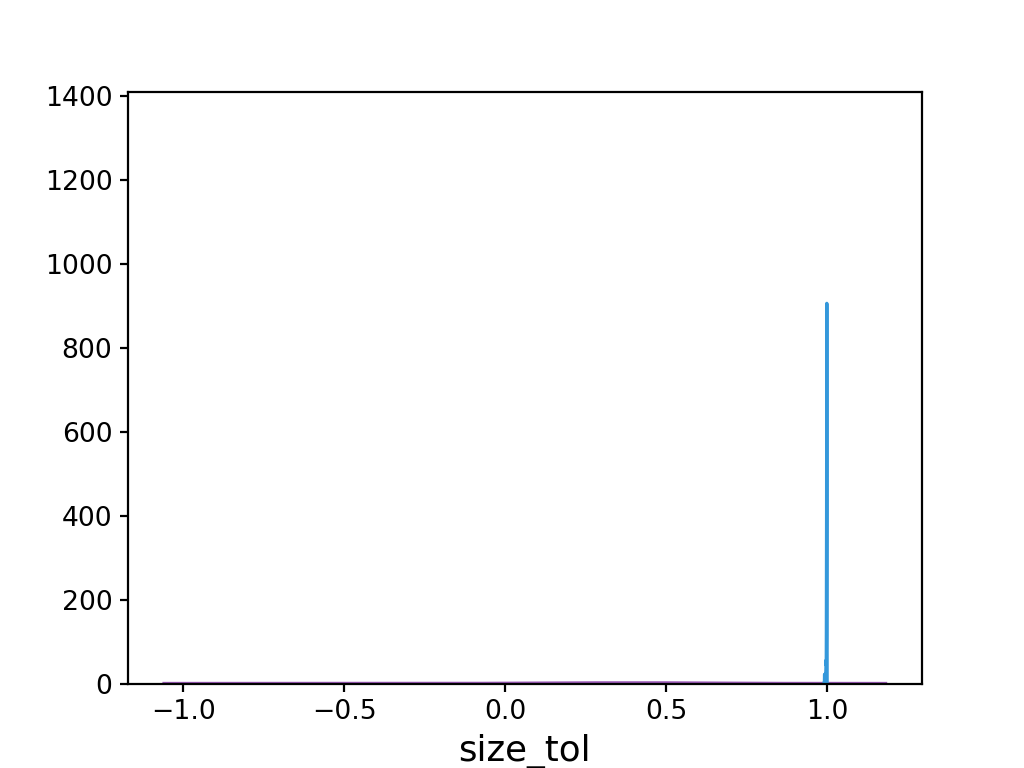

In [800]:
fig, ax = pl.subplots()
sns.distplot(ix1['size_tol'])
sns.distplot(ix2['size_tol'])

<IPython.core.display.Javascript object>


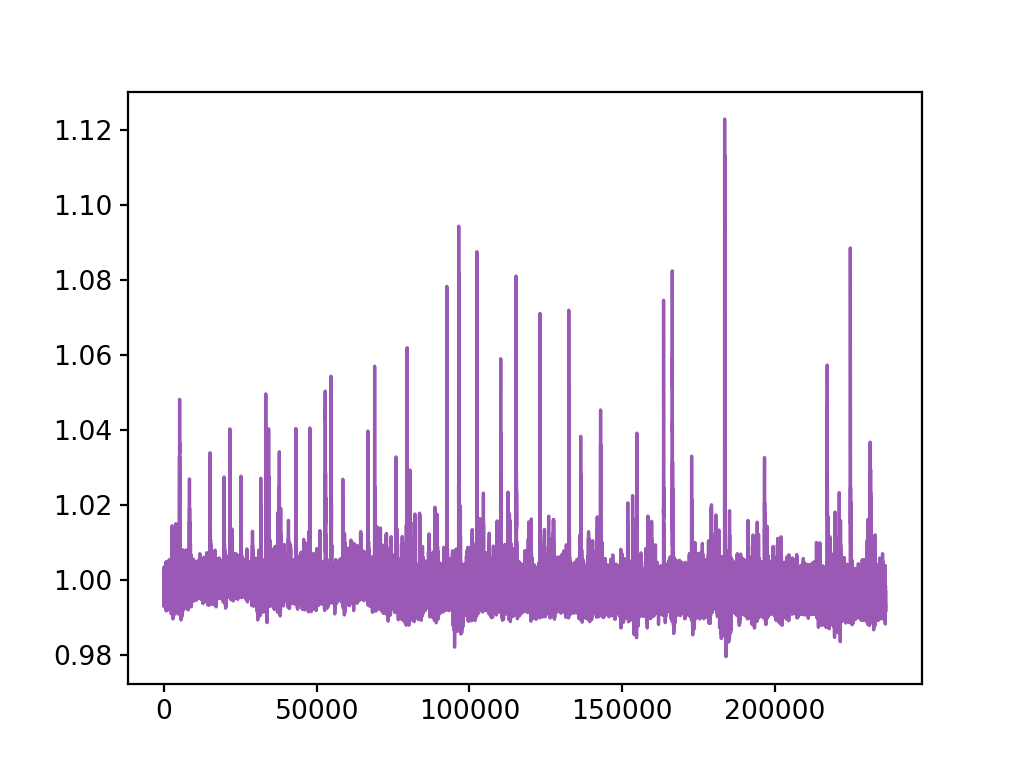

In [773]:
pl.figure()
pl.plot(traces[23])

<IPython.core.display.Javascript object>


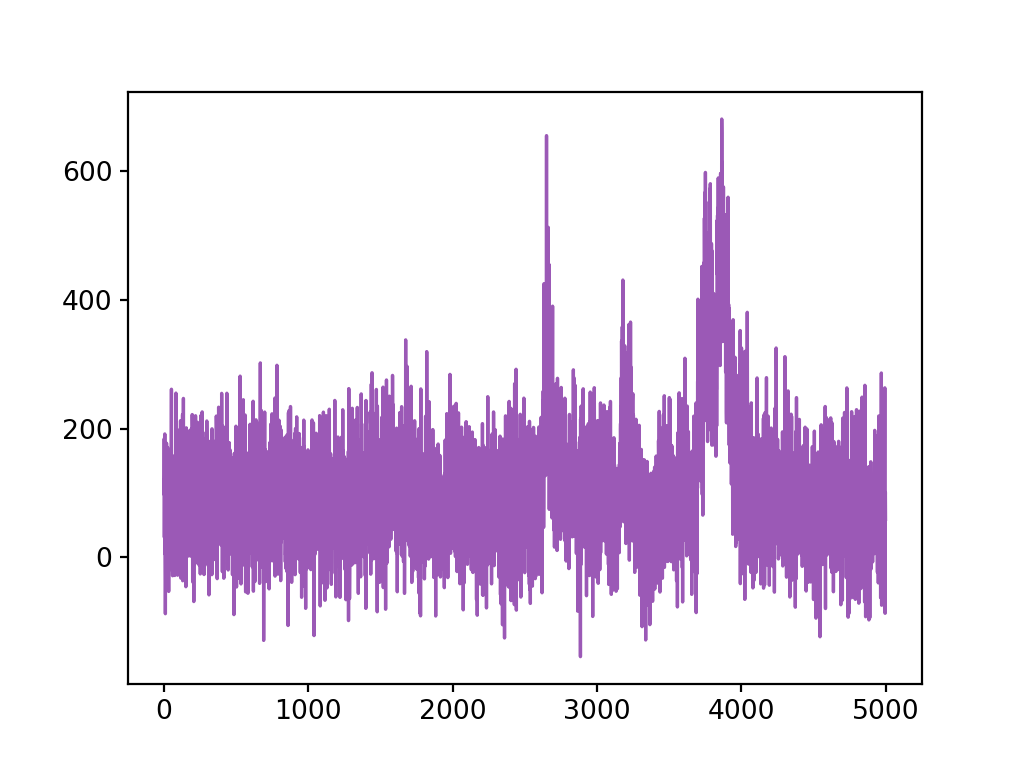

In [700]:
pl.figure()
pl.plot(dset['data'][0:5000, 23])

In [694]:
neuropil = np.load(soma_fpath.replace('np_subtracted', 'neuropil'))
neuropil['data'].min(), neuropil['data'].max()

(-120.99062049062081, 654.8007633587786)

In [689]:
neuropil['f0'].min(), neuropil['f0'].max(), neuropil['f0'].mean()

(6.560815429687501, 8030.35705180921, 376.8797332209979)

In [675]:
neuropil['data'].mean(axis=0).shape

(192,)

In [676]:
dset['data'].shape

(236250, 192)

In [646]:
test = (dset['data']-dset['f0'])/dset['f0']

In [651]:
dset['corrected'].max()

KeyError: 'corrected is not a file in the archive'

In [620]:
inputdata = pd.concat([g for (v, k), g in NDATA.groupby(['visual_area', 'datakey'])\
                     if (v, k) in unique_dkeys])

In [621]:
meanr = inputdata.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()

In [622]:
maxr = meanr.groupby(['visual_area', 'datakey', 'cell']).max().reset_index().drop(['config', 'trial'], axis=1)

In [623]:
min_quant = meanr['response'].describe()['25%']
max_quant = meanr['response'].describe()['75%']
print(min_quant, max_quant)

(532.8621775214257, 965.6301250700395)


In [426]:
maxr.head()

visual_area              datakey  cell  response
0          Li  20190315_JC070_fov1   113  0.602596
1          Li  20190315_JC070_fov1   138  0.576166
2          Li  20190315_JC070_fov1   145  0.589197
3          Li  20190315_JC070_fov1   147  0.575406
4          Li  20190315_JC070_fov1   150  0.591625

In [ ]:
curr_response_thr=0. maxr[maxr['response']>curr_response_thr]


In [490]:
passdf.head()

cell  size_tol  morph_ix  sparseness visual_area              datakey
0   174  0.950670  0.030409    0.000275          Li  20190314_JC070_fov1
1   175  0.948997  0.037606    0.000318          Li  20190314_JC070_fov1
2   177  0.933212  0.037092    0.000561          Li  20190314_JC070_fov1
3   219  0.973580  0.022953    0.000105          Li  20190314_JC070_fov1
4   220  0.975669  0.022626    0.000087          Li  20190314_JC070_fov1

<IPython.core.display.Javascript object>


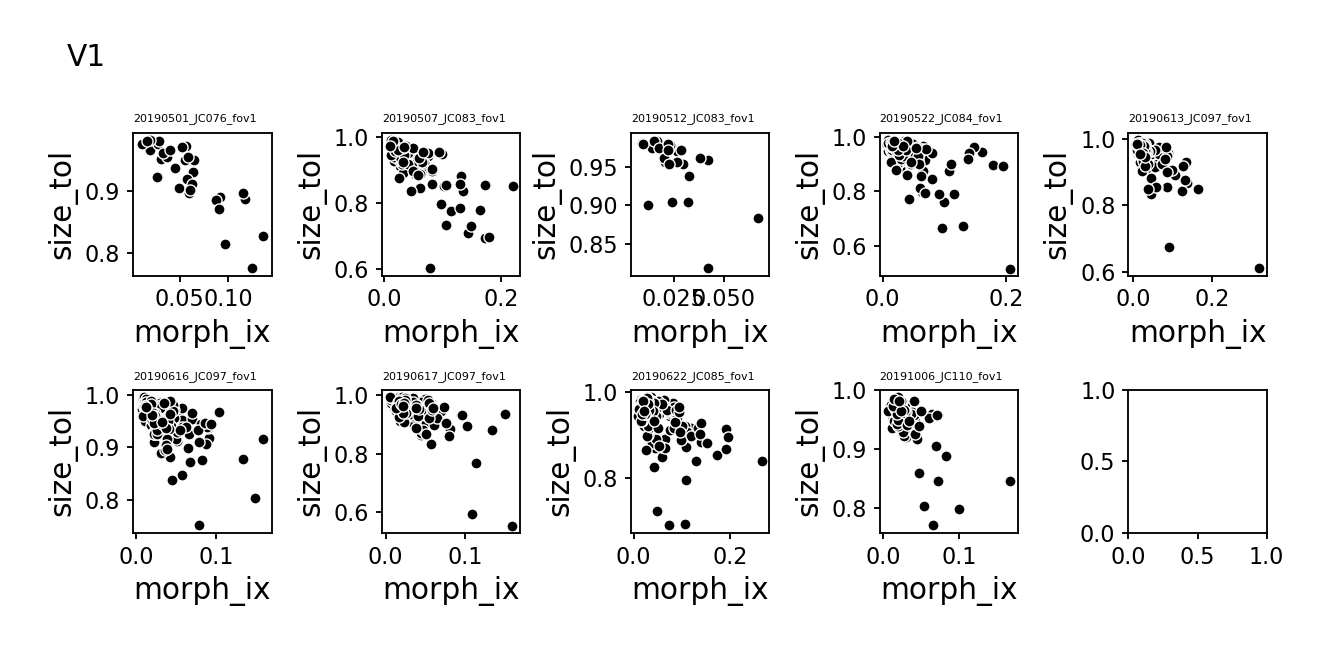

<IPython.core.display.Javascript object>


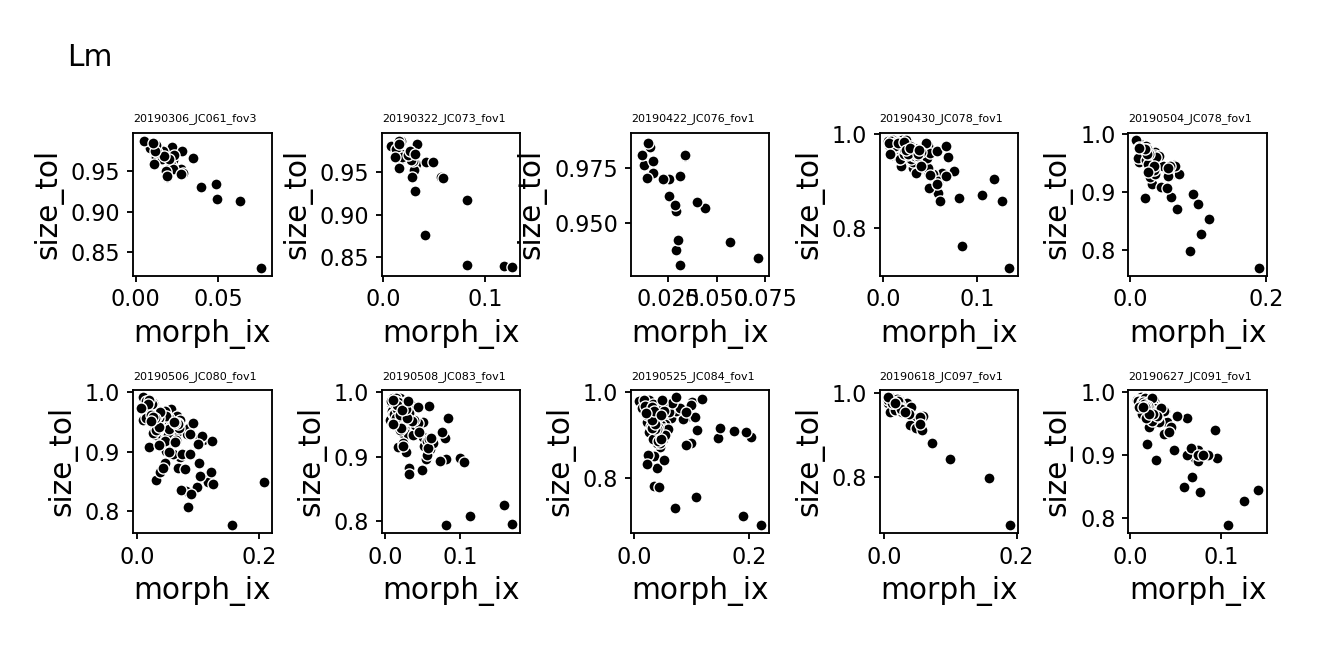

<IPython.core.display.Javascript object>


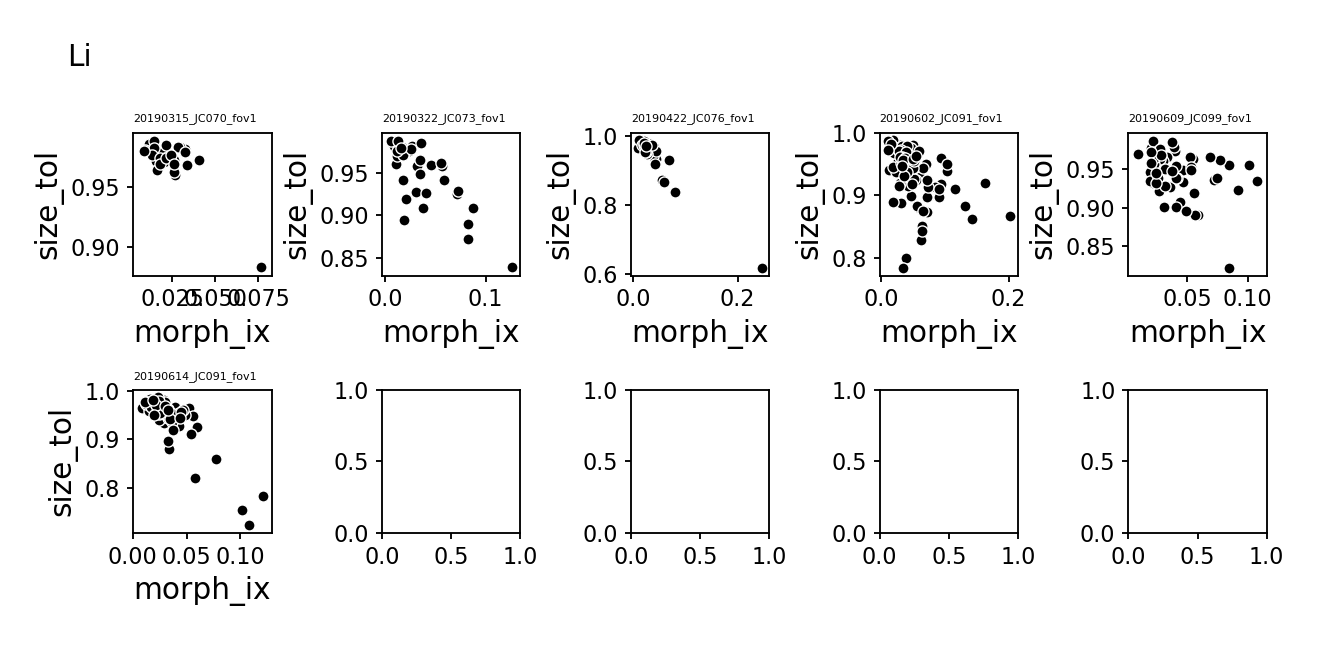

In [341]:
sel_type = 'morph_ix'


for visual_area in visual_areas:
    vg= curr_df[curr_df.visual_area==visual_area].copy()
    n_fovs = len(vg['datakey'].unique())

    fig, axn = pl.subplots(2, 5, figsize=(10, 5), sharex=False, sharey=False)
    for ax, (dk, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):

        pearsons_r, pearsons_p = spstats.pearsonr(ixs_[sel_type], ixs_['size_tol'])
        #sns.regplot(x=sel_type, y='size_tol', data=ixs_, ax=ax, color='k', marker='.')
        sns.scatterplot(x=sel_type, y='size_tol', data=ixs_, ax=ax, color='k', marker='o')
        ax.set_title(dk, loc='left', fontsize=6)
        #ax.set_aspect('equal')
    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    # ax.set_xlim([-0.05, 0.05])
    # ax.set_ylim([-0.2, 0.8])

    fig.text(0.05, 0.9, visual_area, fontsize=16)


In [ ]:
c_=[]
for (va, dk), ixs_ in passdf_drop.groupby(['visual_area', 'datakey']):
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])

In [511]:
CELLS[CELLS['datakey']=='20190502_JC076_fov1']

Empty DataFrame
Columns: [datakey, dset_roi, global_ix, roi, visual_area, animalid, session, fovnum, cell]
Index: []

# size

In [913]:
# if NDATA['response'].min() < 0:
#     NDATA['response'] = NDATA['response'] - NDATA['response'].min()
# print(NDATA['response'].min())

0.0


In [1017]:
visual_area = 'V1'
datakey = '20190616_JC097_fov1' #'20190510_JC083_fov1' #'20191006_JC110_fov1'

# visual_area = 'Li'
# datakey = '20191105_JC117_fov1' #'20190614_JC091_fov1' #'20190510_JC083_fov1' #'20191006_JC110_fov1'

# visual_area = 'Li'
# datakey = '20190614_JC091_fov1' #'20190614_JC091_fov1' #'20190510_JC083_fov1' #'20191006_JC110_fov1'

# visual_area = 'Li'
# datakey = '20190422_JC076_fov1' #'20190614_JC091_fov1' #'20190510_JC083_fov1' #'20191006_JC110_fov1'


x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[datakey].copy() #aggr.get_master_sdf()

print(x0['response'].min(), x0['response'].max())
x0.head()


(-0.35709380403149515, 1.2864820554055088)


visual_area              datakey     config  trial cell  response
0          V1  20190616_JC097_fov1  config004      1    0 -0.029666
1          V1  20190616_JC097_fov1  config023      2    0  0.048854
2          V1  20190616_JC097_fov1  config016      3    0 -0.060115
3          V1  20190616_JC097_fov1  config012      4    0  0.023450
4          V1  20190616_JC097_fov1  config005      5    0  0.049543

In [1018]:
session, animalid, fovn = aggr.split_datakey_str(datakey)
traces, labels = aggr.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
                                                return_traces=True, return_labels=True)


stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]

... calculating F0 for df/f


# Morph selectivity

In [1019]:
x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')

rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
rdf = rdf[rdf['morphlevel']!=-1]

#### Generate morph tuning curves
morph_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='morphlevel', y='size', normalize=True).reset_index(drop=True)
morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')

print(morph_curves['size'].unique())

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)

#### Generate size tuning curves
size_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='size', y='morphlevel', normalize=True).reset_index(drop=True)
size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)


#### Calculate sparseness
sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

[50. 10. 20. 30. 40.]


In [1020]:
#### Aggregate
ixs_ = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1).reset_index()
ixs_.index=ixs_['cell']
ixs_.head()

cell  size_tol  morph_ix  sparseness
cell                                      
0        0  0.805178  0.215545    0.007647
1        1  0.731363  0.068460    0.028965
2        2  0.834057  0.088706    0.005518
9        9  0.902593  0.058931    0.001190
11      11  0.812914  0.087899    0.006336

In [1011]:
x='morphlevel'; y='size';
rid = 119 #217 #405

# [V1] 20190616_JC097_fov1 
# -------------------------------------------
# Tolerant:  217, 388
# 388 (best=10, mid=30, worst=50) | "Purples_r"
# 217 (best=30, mid=20, worst=10) | "Greens_r"


# [Li] 20190422_JC076_fov1 
# -------------------------------------------
# Tolerant:  119, _
# 119 (best=10, mid=30, worst=50) | "Greens_r"
# 76 (best=10, mid=30, worst=40) | "Purples_r"
# 293 (best=50, mid=30, worst=10) | "Greens"


# [Li] 20190614_JC091_fov1
# -------------------------------------------
# Tolerant:  304, 234, 331, 343
# 304 (best=50, mid=20, worst=10) | "Greens"
# 234 (best=30, mid=30, worst=50) | "Purples"
# 343 (best=50, mid=40, worst=10) | "Purples"

In [1013]:


fbest = int(morph_curves[morph_curves['cell']==rid][y].unique())


print(fbest)
curves_mid = rdf.groupby(['cell']).apply(get_x_curves_at_given_size,
                                           x='morphlevel', y='size', val_y=30, normalize=True).reset_index(drop=True)

curves_worst = rdf.groupby(['cell']).apply(get_x_curves_at_given_size,
                                           x='morphlevel', y='size', val_y=50, normalize=True).reset_index(drop=True)

fmid = int(curves_mid[curves_mid['cell']==rid][y].unique())
fworst = int(curves_worst[curves_worst['cell']==rid][y].unique())
morph_rank = [fbest, fmid, fworst]



10


<IPython.core.display.Javascript object>


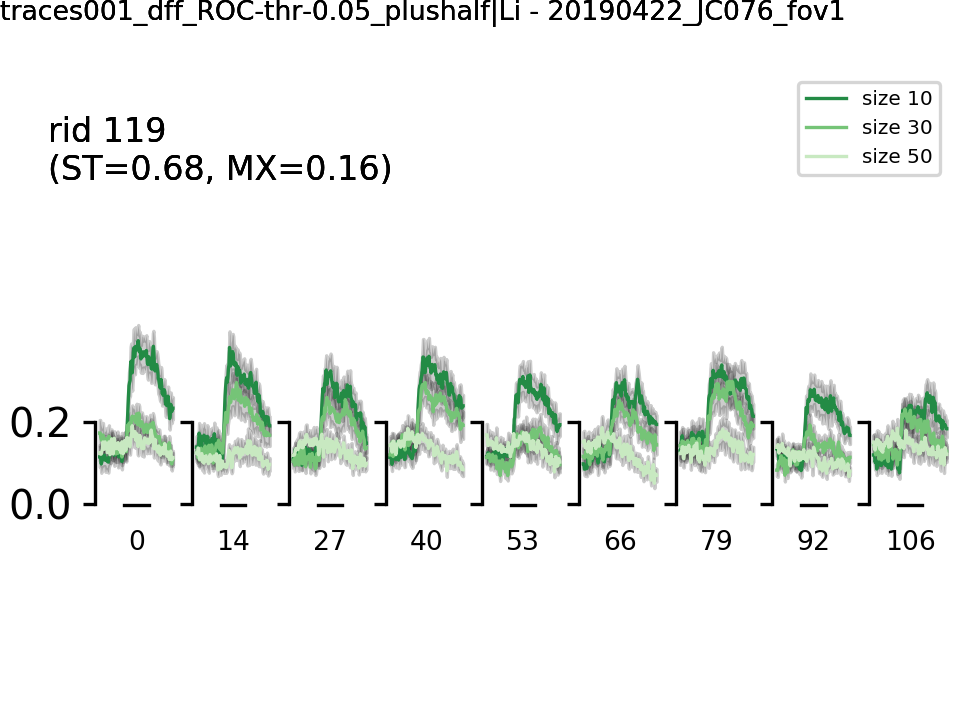

In [1014]:
index_to_plot='morph_ix'
colors=sns.color_palette("Greens_r", n_colors=3)

constant_ = 'morphlevel' if index_to_plot=='size_tol' else 'size'
varying_ = 'size' if constant_=='morphlevel' else 'morphlevel'
curr_cfgs = sdf[(sdf[constant_]==best_one) & (sdf.morphlevel!=-1)].index.tolist()
fig, axn = pl.subplots(1, len(curr_cfgs), figsize=(4, 3), sharex=True, sharey=True, dpi=dpi)
lw=1
for col, best_one in zip(colors, morph_rank):
    curr_cfgs = sdf[(sdf[constant_]==best_one) & (sdf.morphlevel!=-1)].index.tolist()
    rtraces = labels.copy()
    rtraces['dff'] = traces[rid].copy()
    currt = rtraces[rtraces.config.isin(curr_cfgs)]
    
    m_=[]; s_=[];
    for ax, (k, gg) in zip(axn.flat, currt.groupby(['config'])):
        t_df = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=2).unstack().T
        t = np.nanmean(t_df, axis=1)
        s = spstats.sem(t_df, axis=1, nan_policy='omit')
        if fill_sem:
            ax.fill_between(np.arange(0, len(t)), t-s, t+s, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.5, color='gray', alpha=0.5) #'k')
        ax.plot(t, lw=lw, c=col, linestyle=ls, label='%s %i' % (constant_, best_one))
        
        # format
        ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
        ax.tick_params(which='both', axis='x', size=0)
        ax.set_xlabel(sdf[varying_][k], fontsize=8)
        ax.set_xticklabels([])
        ax.set_yticks([0.0, 0.2])
        ax.set_ylim([0.0, 0.7])
    sns.despine(trim=True, offset=0.2)
    pl.subplots_adjust(bottom=0.3, left=0.1, right=0.99, top=0.7)
    ax.legend(bbox_to_anchor=(1, 1.5), loc='upper right', fontsize=6)
    
    fig.text(0.05, 0.75, 'rid %i\n(ST=%.2f, MX=%.2f)' \
             % (rid, ixs_.loc[rid]['size_tol'], ixs_.loc[rid]['morph_ix']))
    
    putils.label_figure(fig, '%s|%s - %s' % (data_id, visual_area, datakey))
    
    pl.savefig(os.path.join(dst_dir, 'examples', 'tolerance_%s_%s_cell%03d.svg' % (visual_area, datakey, rid)))

In [771]:
ixs_.loc[rid]

cell          217.000000
size_tol        0.693934
morph_ix        0.334808
sparseness      0.074522
Name: 217, dtype: float64

In [674]:
ixs_.sort_values(by='morph_ix', ascending=False).head()

cell  size_tol  morph_ix  sparseness
cell                                      
208    208  0.741613  0.379055    0.021671
217    217  0.693934  0.334808    0.074522
253    253  0.802323  0.314325    0.016105
365    365  0.592485  0.308782    0.021829
224    224  0.711071  0.290494    0.016063

In [675]:
# print("Top 5:")
# print(sorted_morph_ixs.iloc[0:5])
# print("Bottom 5:")
# print(sorted_morph_ixs.iloc[-5:])
# print("Top 5:")
# print(sorted_size_tols.iloc[0:5])
# print("Bottom 5:")
# print(sorted_size_tols.iloc[-5:])

<IPython.core.display.Javascript object>


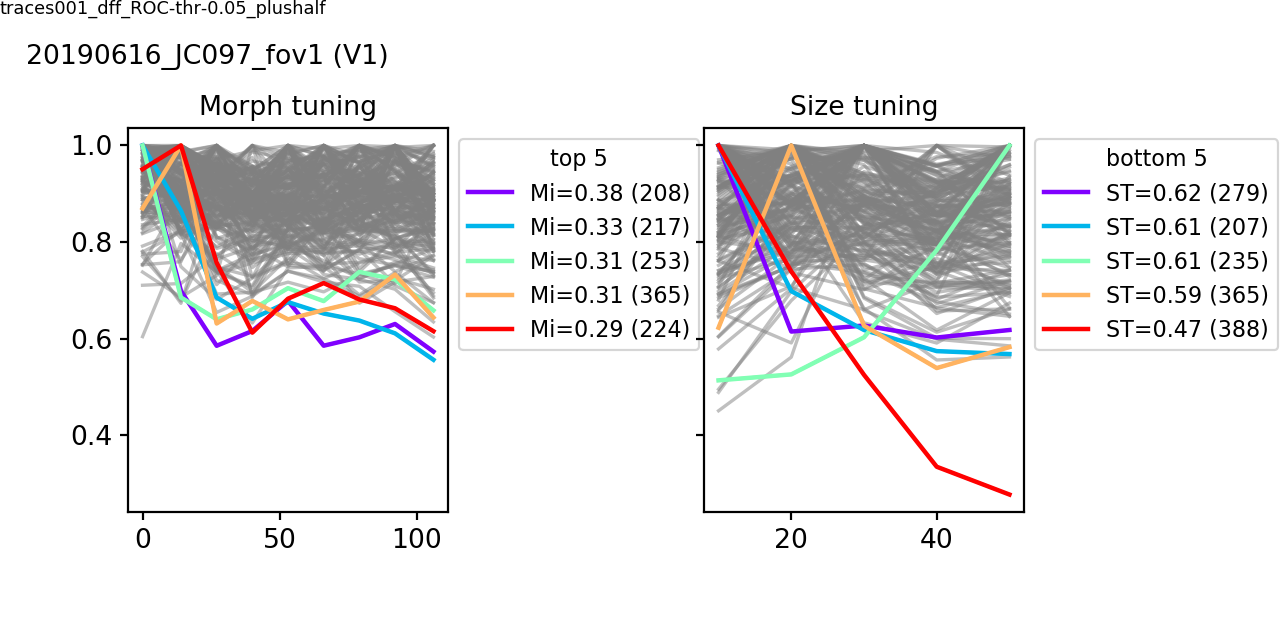

Text(0.02,0.9,u'20190616_JC097_fov1 (V1)')

In [676]:
#### plot topn
topn=5
roi_colors = pl.cm.rainbow(np.linspace(0, 1, topn))

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i)' % (morph_ixs.loc[rid]['morph_ix'], rid))
ax.legend(title='top 5', bbox_to_anchor=(1, 1), loc='upper left')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=0.5)
ax.set_title("Size tuning")
rois_plot_sz = sorted_size_tols.iloc[-topn:].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    ax.plot(size_mat['response', rid], color=col, lw=2, 
            label='ST=%.2f (%i)' % (size_tols.loc[rid]['size_tol'], rid))
ax.legend(title='bottom 5', bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(wspace=0.8, left=0.1, right=0.8, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)
fig.text(0.02, 0.9, '%s (%s)' % (datakey, visual_area), fontsize=12)

In [534]:
ixs_.loc[294]

cell          294.000000
size_tol        0.736355
morph_ix        0.221049
sparseness      0.010975
Name: 294, dtype: float64

In [53]:
x0.groupby(['cell', 'config'])['response'].mean().groupby(['cell']).max().sort_values(ascending=False)

cell
304    0.582501
31     0.562538
234    0.544709
343    0.499740
28     0.441474
37     0.426663
15     0.409768
14     0.403973
22     0.393949
11     0.390571
277    0.379757
26     0.376757
34     0.374822
19     0.372203
20     0.370862
331    0.363494
248    0.356992
80     0.356848
53     0.339826
333    0.338672
43     0.336350
60     0.335765
50     0.313040
58     0.312593
25     0.311264
59     0.306381
289    0.305290
384    0.302928
529    0.295132
316    0.295006
         ...   
85     0.263696
327    0.262050
285    0.261466
169    0.261429
51     0.259839
75     0.257884
219    0.256842
256    0.256557
311    0.254744
166    0.251135
523    0.250973
521    0.249781
305    0.246881
252    0.245381
47     0.241013
257    0.240860
211    0.239230
332    0.237825
317    0.235483
267    0.234320
209    0.232123
167    0.223117
399    0.221684
176    0.213107
266    0.208383
242    0.207009
272    0.203510
251    0.202981
235    0.193164
261    0.183992
Name: response, Len

In [54]:
# 18: morph_selective, bad size tol.
# 162:  good size tol, 

<IPython.core.display.Javascript object>


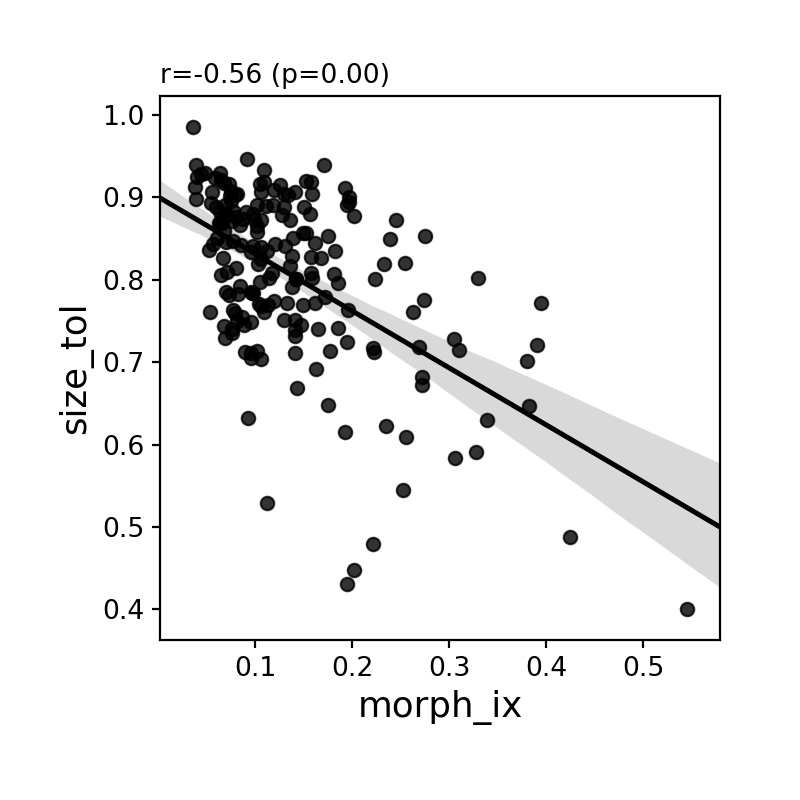

In [602]:
fig, ax = pl.subplots(figsize=(5,5))
sns.regplot(x='morph_ix', y='size_tol', data=ixs_, ax=ax, color='k')
pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_['morph_ix'])
ax.set_title("r=%.2f (p=%.2f)" % (pearsons_r, pearsons_p), loc='left')
pl.subplots_adjust(left=0.2, bottom=0.2)

In [531]:
print(rois_plot_mp)
print(rois_plot_sz)
rois_plot = np.union1d(rois_plot_mp, rois_plot_sz)


[76, 309, 293, 186, 294]
[309, 119, 293, 284, 76]


In [532]:
vmin = rdf[rdf.cell.isin(rois_plot)]['response'].min()
vmax = rdf[rdf.cell.isin(rois_plot)]['response'].max()
print(vmin, vmax)

(0.08447203131446608, 0.43981974624995746)


<IPython.core.display.Javascript object>


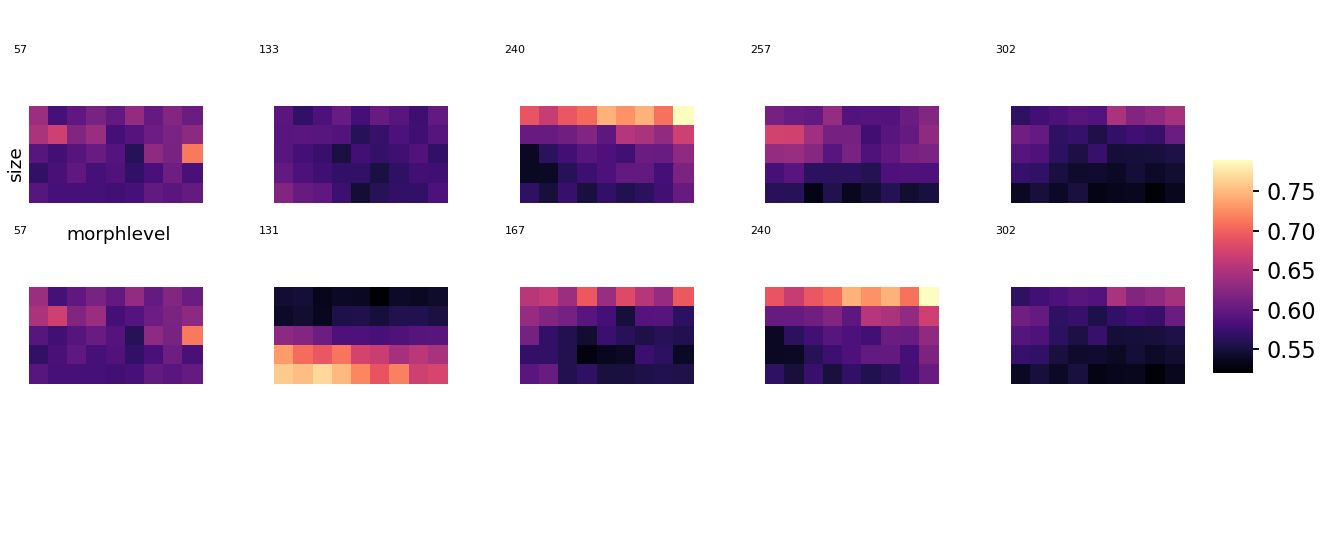

In [718]:
cmap='magma'
fig, axn = pl.subplots(2, topn, sharex=True, sharey=True, figsize=(10,4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_mp)].groupby(['cell'])):
    ax=axn[0, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
fig.text(0.005, 0.7, 'size', rotation=90)
fig.text(0.05, 0.55, 'morphlevel', rotation=0)

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_sz)].groupby(['cell'])):
    ax=axn[1, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
    
pl.subplots_adjust(left=0.01, right=0.9, bottom=0.2, hspace=0.0)

### Sekect best examples

In [64]:
if not os.path.exists(os.path.join(dst_dir, 'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))

<IPython.core.display.Javascript object>


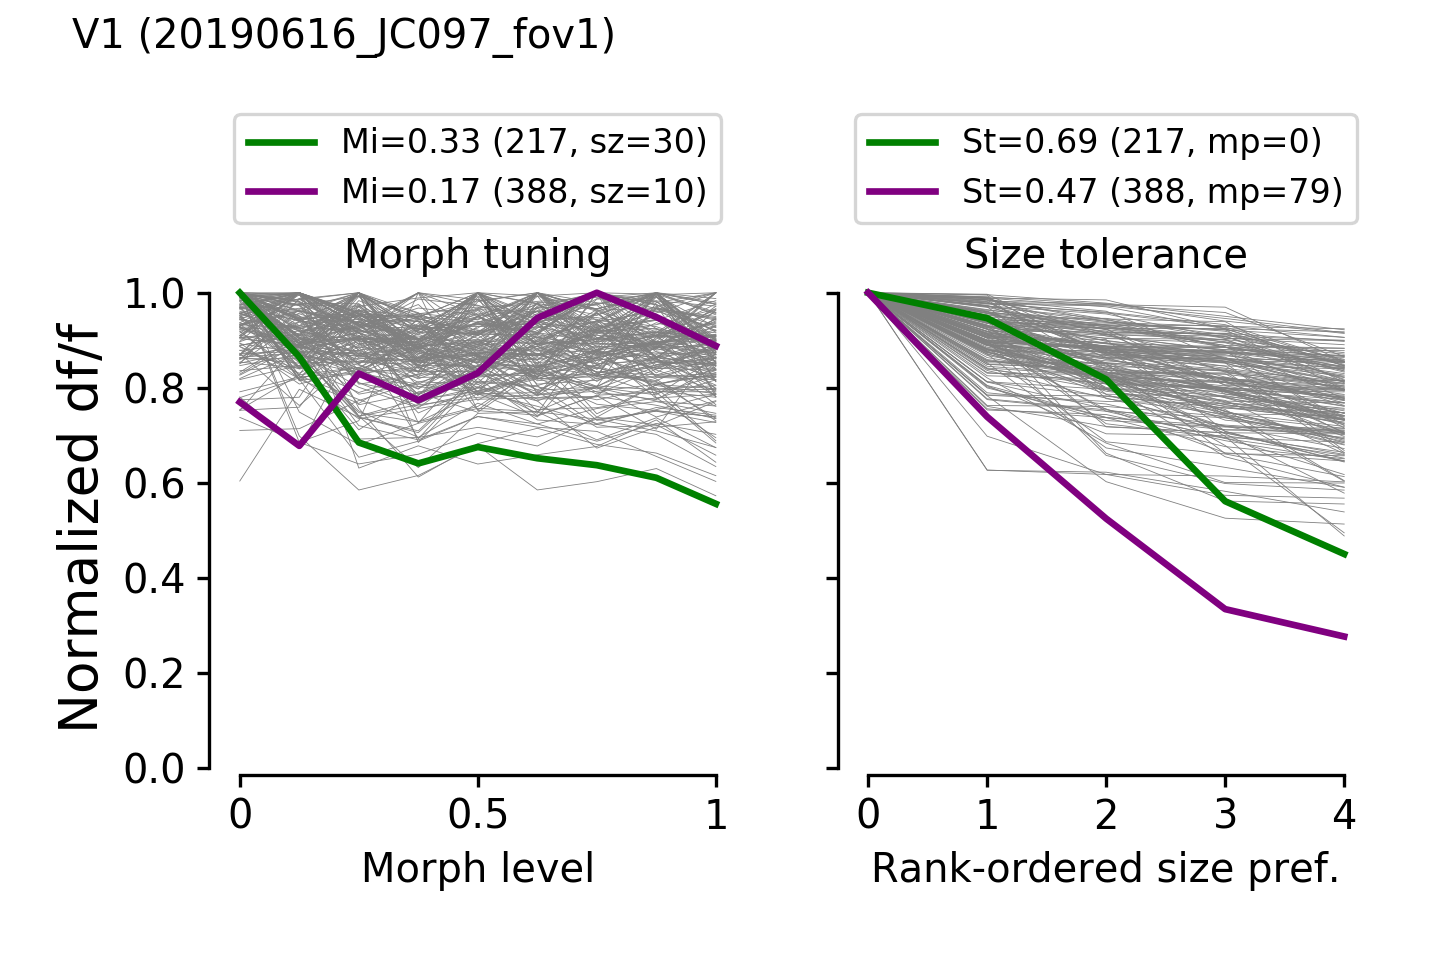

In [1021]:
roi_labels = ['high', 'low'] # 'all']
# roi_colors = ['black',  'black'] #, 'k']
# roi_styles = ['-', '--']
roi_colors = ['green',  'purple'] #, 'k']
roi_styles = ['-', '-']

# V1: 20190616_JC097_fov1
# -----------------------
rois_plot_mp = [217, 388] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
#rois_plot_sz = [405, 388] #405#[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()
rois_plot_sz = [217, 388]

# # # Li: 20190607_JC091_fov
# rois_plot_mp = [304, 343]
# rois_plot_sz = [304, 343]

# # # Li: 20190607_JC091_fov
# rois_plot_mp = [343, 331] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [304, 234] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

# # Li: 20191105_JC117_fov1
# rois_plot_mp = [67, 38] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [78, 19] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

# # Li: 20190422_JC076_fov1
# rois_plot_mp = [119, 76]
# # rois_plot_sz = [294, 76] 
# rois_plot_sz = [119, 76] 

rank_order=False
size_labels = sorted(sdf['size'].unique())
morph_labels = sorted(sdf['morphlevel'].unique())

fig, axn = pl.subplots(1,2, figsize=(6,4), sharey=True, dpi=dpi)

ax=axn[0]

if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
    
ax.plot(mm.values, color='gray', alpha=1, lw=0.25)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(mm['response', rid].values, color=col, lw=2, linestyle=ls,
                label='Mi=%.2f (%i, sz=%i)' % (ixs_.loc[rid]['morph_ix'], rid, best_sz))
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)

ax.set_xlabel(xlabel, fontsize=12)
ax.legend( bbox_to_anchor=(0.5, 1.1), loc='lower center')
ax.set_ylim([0, 1])

ax=axn[1]
rank_order=True
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0)
    sz = xx[::-1]
else:
    sz = morph_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=0.25)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())
    ax.plot(sz['response', rid].values, color=col, lw=2, linestyle=ls,
                label='St=%.2f (%i, mp=%i)' % (ixs_.loc[rid]['size_tol'], rid, best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) if rank_order else size_labels
ax.set_xticks(np.arange(0, len(size_labels)))
ax.set_xticklabels(xticks)

ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.1), loc='lower center')

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (visual_area, datakey), fontsize=12)

pl.subplots_adjust(wspace=0.2, left=0.15, right=0.95, top=0.7, bottom=0.2)

figname = 'example_ranked_tolerance_selectivity__%s_%s' % (visual_area, datakey)
#pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))

In [691]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

... calculating F0 for df/f


<IPython.core.display.Javascript object>


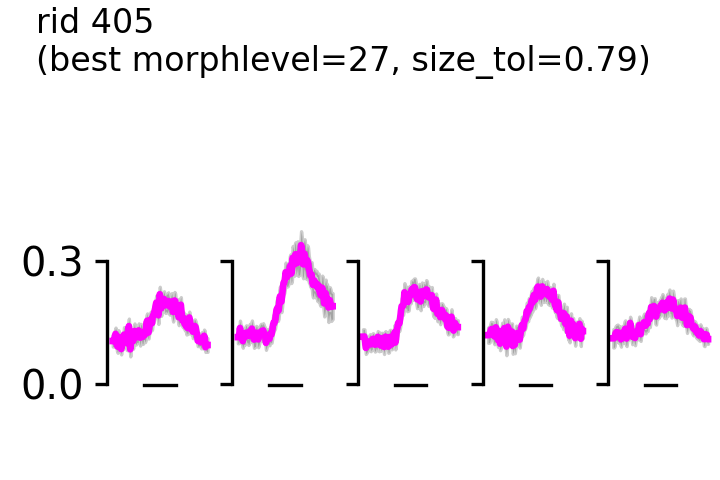

<IPython.core.display.Javascript object>


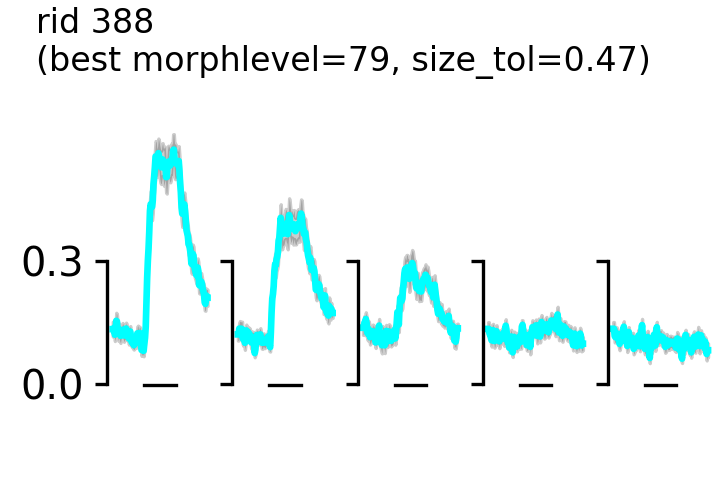

In [699]:
index_to_plot = 'size_tol'
other_cond = 'morphlevel' if index_to_plot=='size_tol' else 'size'
curr_rois = rois_plot_sz if index_to_plot=='size_tol' else rois_plot_mp
curr_curves = size_curves.copy() if index_to_plot=='size_tol' else morph_curves.copy()
fwidth = 3 if index_to_plot=='morph_ix' else 3

lw=2
fill_sem=True
for rid, lc, ls,  in zip(curr_rois, roi_colors, roi_styles):
    best_one = int(curr_curves[curr_curves['cell']==rid][other_cond].unique())
    if index_to_plot=='size_tol':
        curr_cfgs = sdf[(sdf[other_cond]==best_one) & (sdf.morphlevel!=-1)].index.tolist()
    else:
        curr_cfgs = sdf[(sdf[other_cond]==best_one) & (sdf.morphlevel!=-1)].index.tolist()[0::2]
    rtraces = labels.copy()
    rtraces['dff'] = traces[rid].copy()
    currt = rtraces[rtraces.config.isin(curr_cfgs)]
    
    fig, axn = pl.subplots(1, len(curr_cfgs), figsize=(fwidth, 2), sharex=True, sharey=True, dpi=dpi)

    m_=[]; s_=[];
    for ax, (k, gg) in zip(axn.flat, currt.groupby(['config'])):
        #print(sdf.loc[k])
        #t_df = pd.DataFrame(np.vstack(g.groupby(['trial'])['dff'].apply(np.array).values))
        #t = np.nanmean(t_df, axis=0)
        #s = spstats.sem(t_df, axis=0, nan_policy='omit')
        
        t_df = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=2).unstack().T
        t = np.nanmean(t_df, axis=1)
        s = spstats.sem(t_df, axis=1, nan_policy='omit')
        
        if fill_sem:
            ax.fill_between(np.arange(0, len(t)), t-s, t+s, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.5, color='gray', alpha=0.5) #'k')
        ax.plot(t, lw=lw, c=lc, linestyle=ls)
        
        # format
        ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
        ax.tick_params(which='both', axis='x', size=0)
        ax.set_xticklabels([])
        ax.set_yticks([0, 0.3])
        ax.set_ylim([0, 0.7])
    sns.despine(trim=True, offset=0.2)
    
    fig.text(0.05, 0.85, 'rid %i\n(best %s=%i, %s=%.2f)' % (rid, other_cond, best_one, index_to_plot,
                                                                ixs_.loc[rid][index_to_plot]))
    pl.subplots_adjust(bottom=0.2, left=0.15, right=0.99, top=0.8)
    
    pl.savefig(os.path.join(dst_dir, 'examples', 'morphtuning_%s_%s_cell%03d.svg' % (visual_area, datakey, rid)))

In [586]:
xdf[xdf['datakey']=='20190605_JC090_fov1']

Empty DataFrame
Columns: [cell, size_tol, morph_ix, sparseness, visual_area, datakey]
Index: []

In [104]:
CELLS[(CELLS['visual_area']=='Li') & (CELLS.datakey=='20191105_JC117_fov1')]

Empty DataFrame
Columns: [datakey, dset_roi, global_ix, roi, visual_area, animalid, session, fovnum, cell]
Index: []

In [105]:
NDATA['20191105_JC117_fov1']

NameError: name 'MEANS' is not defined

In [458]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

def downsample_array(roi_trace, temporal_ds=5):
    #print('Performing temporal smoothing on traces...')
    windowsz = int(temporal_ds)
    smooth_roi_trace = roi_trace.apply(temporal_downsample, args=(windowsz,), axis=0)
    return smooth_roi_trace


def smooth_timecourse(in_trace, win_size=41):
    #smooth trace

    trace_pad = np.pad(in_trace, ((win_size/2, win_size/2)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

In [471]:
rid=19 #78
rtraces = labels.copy()
rtraces['dff'] = traces[rid].copy()
g = rtraces[rtraces.config.isin(curr_cfgs)]
t_df = pd.DataFrame(np.vstack(g.groupby(['trial'])['dff'].apply(np.array).values))

In [472]:
def mean_traces_config(gg, win_size=5):
    return pd.Series(gg.groupby(['trial'])['dff'].apply(np.array).mean(axis=0), name=gg['config'].unique()[0])

def smooth_traces_config(gg, win_size=5):
    d = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=45).unstack().T
    return d

def smooth_then_mean(gg, win_size=5):
    return pd.Series(gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=win_size).unstack().mean(axis=0),
                     name=gg['config'].unique()[0])


def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)

In [473]:
smooth_means = g.groupby(['config']).apply(smooth_then_mean, win_size=45).T

In [474]:
means = g.groupby(['config']).apply(mean_traces_config).T
smooths = means.apply(smooth_traces_trial, win_size=45)

In [475]:
smooths = means.apply(smooth_traces_trial, win_size=45)

In [476]:
s_trials = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=30).unstack().T


<IPython.core.display.Javascript object>


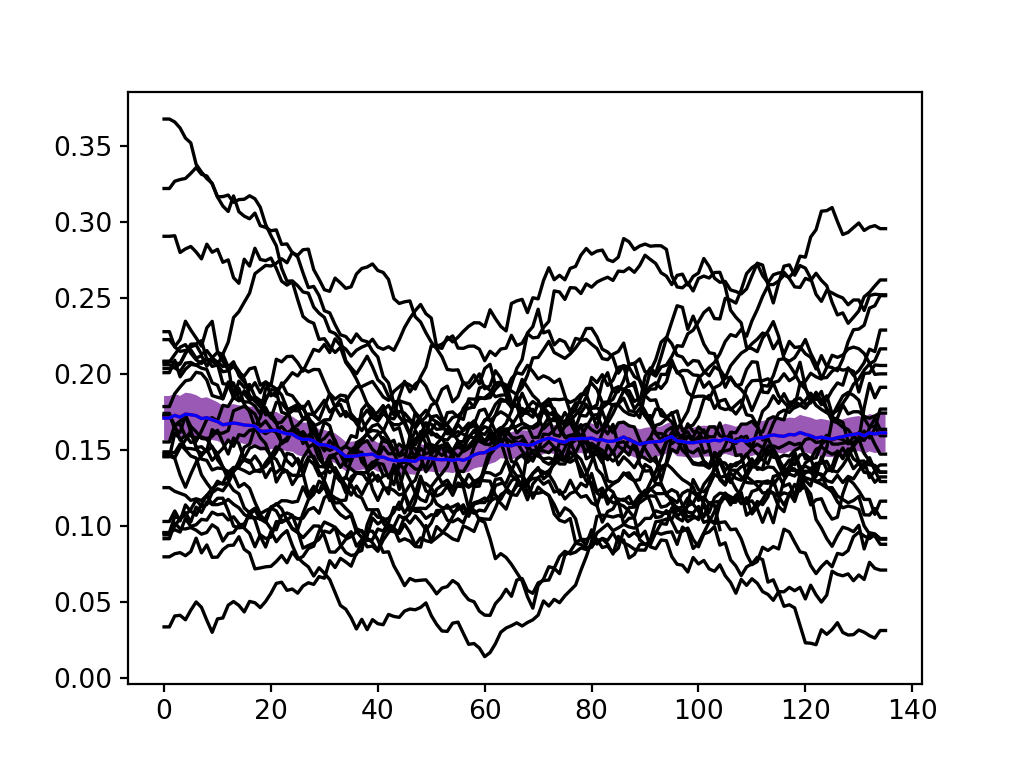

In [477]:
fig, ax = pl.subplots()
ax.plot(s_trials, color='k')
ax.plot(s_trials.mean(axis=1), color='r')


t = np.nanmean(s_trials, axis=1)
s = spstats.sem(s_trials, axis=1, nan_policy='omit')
        
ax.plot(t, 'b')
ax.fill_between(np.arange(0, len(t)), t-s, t+s)

<IPython.core.display.Javascript object>


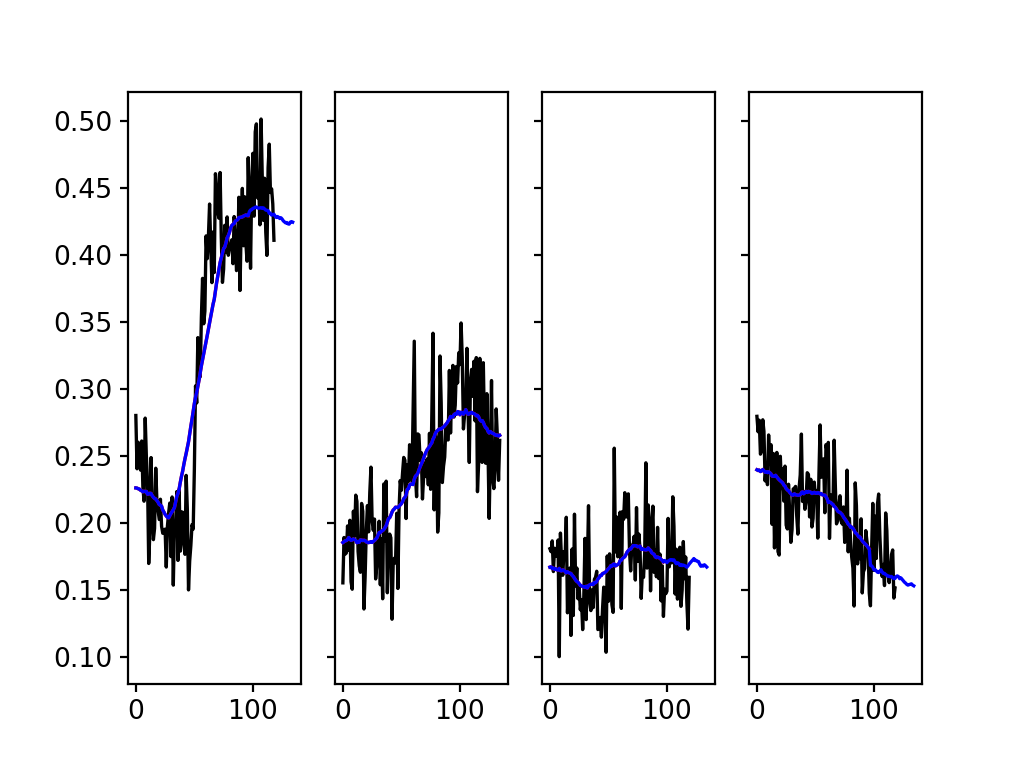

In [478]:
in_trace=t_df[0].values

fig, axn = pl.subplots(1,4, sharex=True, sharey=True)
for ax, cfg in zip(axn.flat, curr_cfgs):
    ax.plot(means[cfg].values, color='k')
    ax.plot(smooths[cfg].values, color='r')
    ax.plot(smooth_means[cfg].values, color='b')

In [455]:
t_df = pd.DataFrame(np.vstack(g.groupby(['trial'])['dff'].apply(np.array).values))
s_df = downsample_array(t_df, 100)
t = np.nanmean(t_df, axis=0)

In [ ]:
pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                            for trial, g in labels.groupby(['trial'])]),
                                             columns=roi_list, index=trial_list)

In [726]:
rdf[rdf['response']>=0.65]['cell'].unique()

array([ 57, 104, 107, 131, 167, 240, 257])

<IPython.core.display.Javascript object>


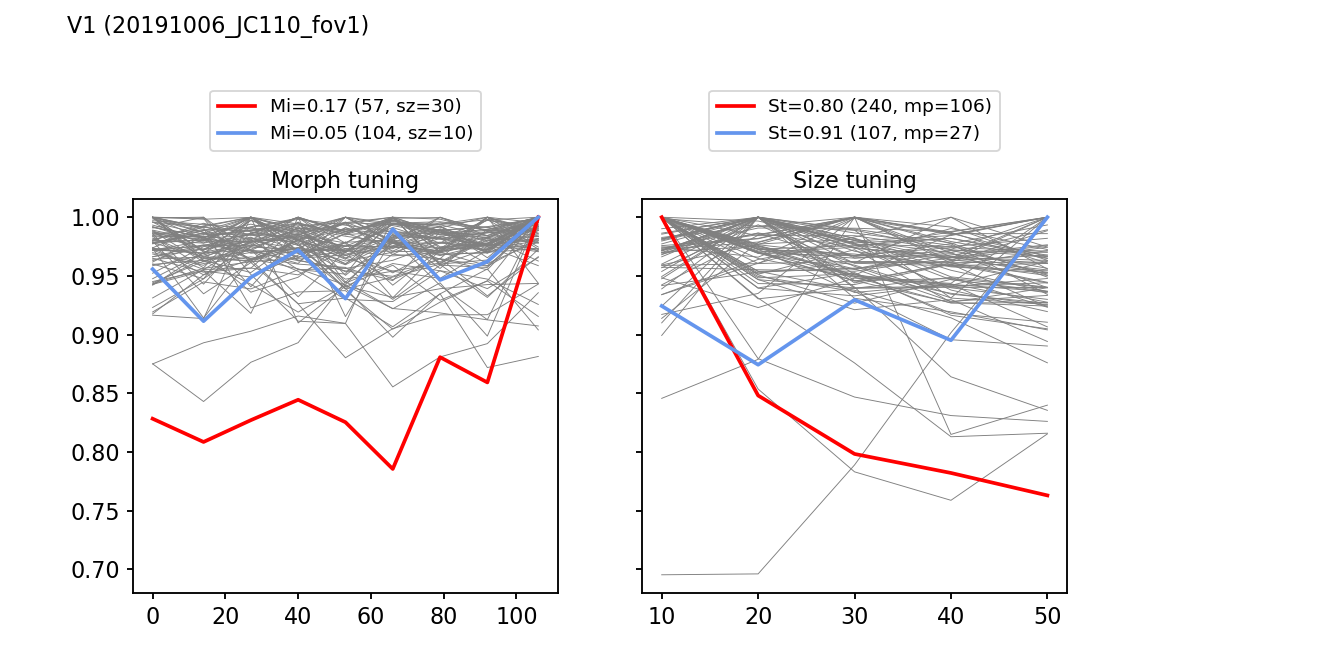

In [877]:
#### 20191006_JC110_fov
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['red',  'cornflowerblue'] #, 'k']

fig, axn = pl.subplots(1,2, figsize=(10,5), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = [57, 104] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i, sz=%i)' % (morph_ixs.loc[rid]['morph_ix'], rid, best_sz))
ax.legend( bbox_to_anchor=(0.5, 1.1), loc='lower center')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Size tuning")
rois_plot_sz = [240, 107] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())

    ax.plot(size_mat['response', rid], color=col, lw=2, 
                label='St=%.2f (%i, mp=%i)' % (size_tols.loc[rid]['size_tol'], rid, best_mp))
ax.legend(bbox_to_anchor=(0.5, 1.1), loc='lower center')
fig.text(0.05, 0.95, '%s (%s)' % (visual_area, datakey), fontsize=12)

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.8, top=0.7)

In [845]:
int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())


27.0

In [647]:
rdf['response'].max()

0.7902469373691154

(0.5027450171082631, 0.6952031131698545)


IndexError: too many indices for array

In [609]:
rd['response'].reshape(9,5), 

array([[0.56981777, 0.57364562, 0.57375215, 0.55965782, 0.56425996],
       [0.57422147, 0.57669009, 0.57923581, 0.56084349, 0.57725106],
       [0.57410796, 0.58175806, 0.5784192 , 0.57808927, 0.5642958 ],
       [0.57542556, 0.57528589, 0.5706843 , 0.57750307, 0.57349688],
       [0.57701489, 0.58601119, 0.5711773 , 0.57715875, 0.56912394],
       [0.57754534, 0.56815715, 0.57131692, 0.58317837, 0.5616384 ],
       [0.57111548, 0.57836632, 0.58707754, 0.57886591, 0.57886694],
       [0.57311267, 0.57492115, 0.57766264, 0.5637506 , 0.56955009],
       [0.56571723, 0.57896397, 0.57751257, 0.57485   , 0.56766112]])

<IPython.core.display.Javascript object>


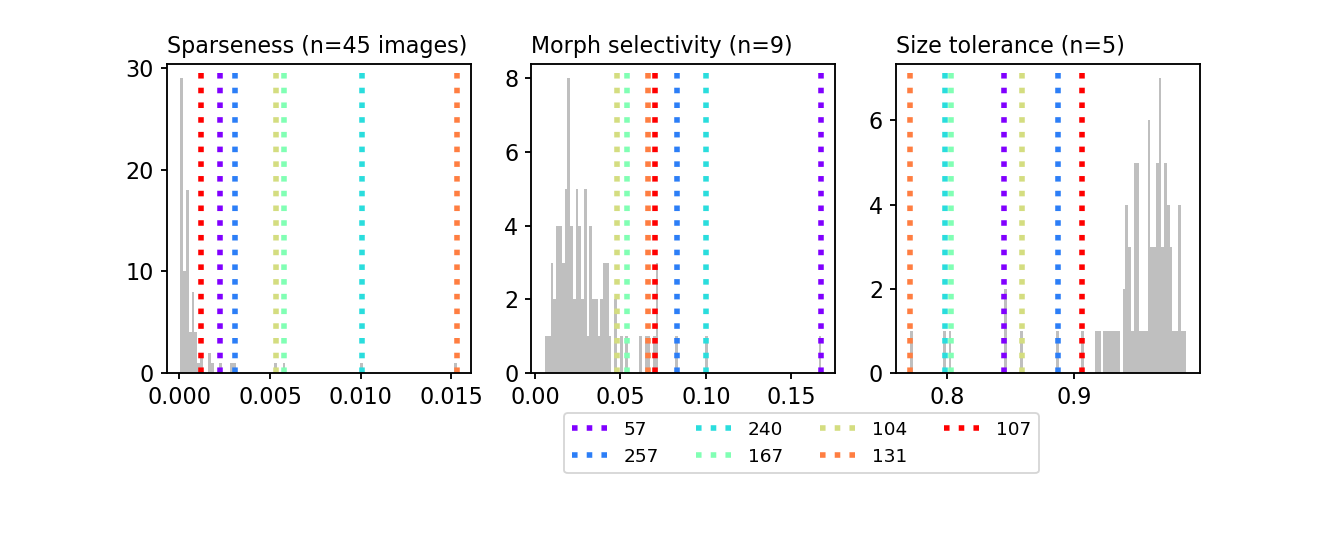

In [889]:


n_images = len(rdf['config'].unique())
n_morphs = len(np.unique([sdf['morphlevel'][c] for c in rdf['config'].unique()]))
n_sizes = len(np.unique([sdf['size'][c] for c in rdf['config'].unique()]))


rois_plot = [57, 257, 240, 167, 104, 131, 107]
color=pl.cm.rainbow(np.linspace(0, 1, len(rois_plot)))

fig, axn = pl.subplots(1,3, figsize=(10,4))

#### Sparsensess
ax=axn[0]
ax.hist(ixs_['sparseness'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['sparseness'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Sparseness (n=%i images)' % n_images, loc='left')

#### Morph selectivity
ax=axn[1]
ax.hist(ixs_['morph_ix'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['morph_ix'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Morph selectivity (n=%i)' % n_morphs, loc='left')

#### Size tuning
ax=axn[2]
ax.hist(ixs_['size_tol'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['size_tol'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Size tolerance (n=%i)' % n_sizes, loc='left')

ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=4)
pl.subplots_adjust(bottom=0.3)



In [883]:
ixs_['size_tol']

cell
4      0.982325
5      0.963247
6      0.947806
11     0.942069
12     0.973949
24     0.959558
33     0.977246
38     0.971439
46     0.968502
55     0.968547
57     0.844817
61     0.951170
65     0.943397
76     0.948799
77     0.950042
79     0.957870
85     0.974221
86     0.972298
100    0.950989
101    0.977810
102    0.953107
103    0.944793
104    0.858944
106    0.932196
107    0.905845
108    0.956141
112    0.942284
116    0.949694
118    0.918031
121    0.959964
         ...   
243    0.979516
248    0.970308
252    0.982175
255    0.925457
257    0.887450
267    0.975909
275    0.948866
276    0.941952
279    0.964935
285    0.974794
298    0.971071
301    0.969143
302    0.845798
304    0.958465
305    0.982484
307    0.963955
310    0.965554
325    0.965214
336    0.968281
337    0.967287
338    0.940227
353    0.961225
354    0.959225
355    0.988202
356    0.966682
364    0.948350
375    0.973809
380    0.985668
383    0.964546
390    0.982500
Name: size_tol, Len

In [884]:
r

107

In [ ]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

# Stdev?

In [8]:
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
m = x0.groupby(['cell', 'config']).mean().reset_index()


n2 = aggr.stacked_neuraldf_to_unstacked(m)
n2.shape
n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
n3['config'] = n2['config'].values
ndf = aggr.unstacked_neuraldf_to_stacked(n3)

sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)


NameError: name 'visual_area' is not defined

In [ ]:
fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [139]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [189]:
t_=[]
for (visual_area, datakey), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = SDF[datakey].copy()
    #ndf = x0.copy()    
    m = x0.groupby(['cell', 'config']).mean().reset_index()
    n2 = aggr.stacked_neuraldf_to_unstacked(m)
    n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
    n3['config'] = n2['config'].values
    ndf = aggr.unstacked_neuraldf_to_stacked(n3)

#     rois_ = [r for r in x1.columns if putils.isnumber(r)]
#     x2 = x1[rois_].subtract(x1[rois_].min(axis=0))
#     x2['config'] = x1['config']
#     x2['trial'] = x2.index.tolist()
#     ndf = pd.melt(x2, id_vars=['config', 'trial'], var_name='cell', value_name='response')

    sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

    mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

    sz1 = sz_df.copy() #sz_df.divide(sz_df.sum(axis=1), axis=0)
    mp1 = mp_df.copy() #mp_df.divide(mp_df.sum(axis=1), axis=0)

    stds_sz = pd.DataFrame(sz1.std(axis=1), columns=['std'])
    stds_sz['condition'] = 'size'

    stds_mp = pd.DataFrame(mp1.std(axis=1), columns=['std'])
    stds_mp['condition'] = 'morphlevel'

    tmpdf = pd.concat([stds_sz, stds_mp], axis=0)
    tmpdf['cell'] = tmpdf.index.tolist()
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey']=datakey
    
    t_.append(tmpdf)

In [190]:
df = pd.concat(t_, axis=0)
df.head()

std condition  cell visual_area              datakey
cell                                                           
174   0.000041      size   174          Li  20190314_JC070_fov1
175   0.000028      size   175          Li  20190314_JC070_fov1
177   0.000059      size   177          Li  20190314_JC070_fov1
219   0.000023      size   219          Li  20190314_JC070_fov1
220   0.000017      size   220          Li  20190314_JC070_fov1

#### plot fits

<IPython.core.display.Javascript object>


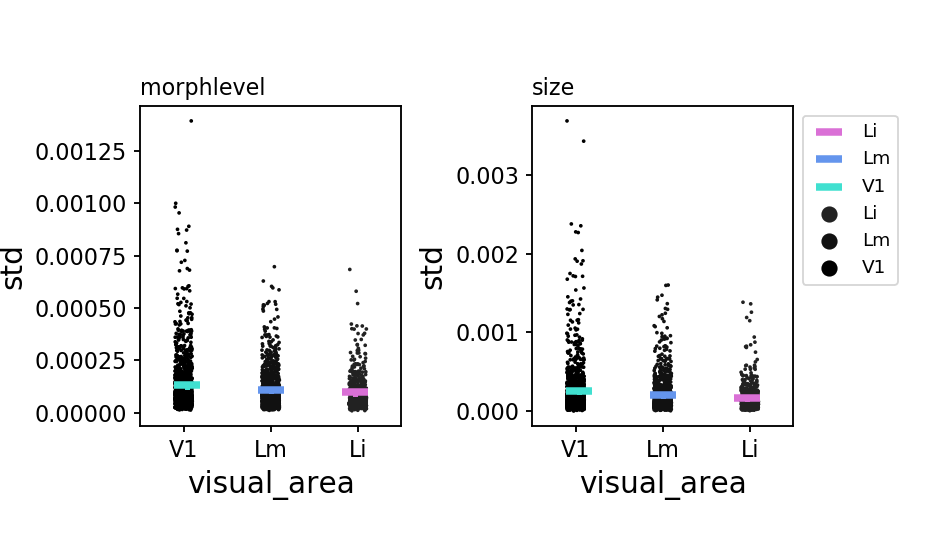

In [191]:

fig, axn = pl.subplots(1,2, figsize=(7,4))
    
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, df.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    
    sns.stripplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', color='k', order=visual_areas, size=2, zorder=-1)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.set_title(cond, loc='left')

pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

#### means by fov

<IPython.core.display.Javascript object>


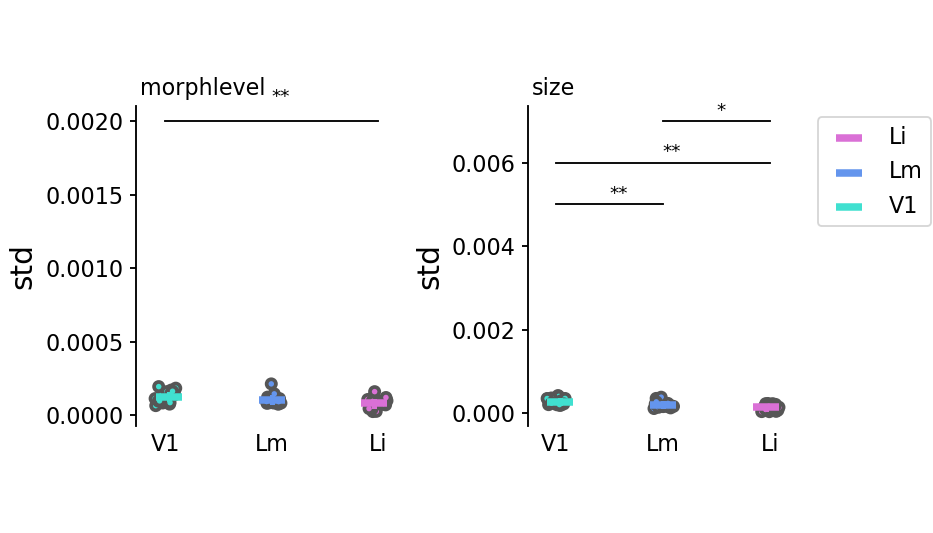

********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.060 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.009 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.091 (fdr_bh), reject H0=False
****************************
********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.005 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.013 (fdr_bh), reject H0=True
****************************


In [192]:
multi_comp_test='fdr_bh'

means_by_fov = df.groupby(['visual_area', 'datakey', 'condition' ]).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(7,4))
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, means_by_fov.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    sns.stripplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, size=5, zorder=-1,
                 marker='o', linewidth=2) #, edgecolor=area_colors)
    
    yloc = 0.005 if cond=='size' else 0.001
    offset=0.001 if cond=='size' else 0.001
    statresults, ax = aggr.plot_mannwhitney(mg, metric='std', multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=yloc, offset=offset)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_title(cond, loc='left')

aggr.crop_legend_labels(axn[-1], n_hues=3)

sns.despine(offset=2, bottom=True)
pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)